In [150]:
%matplotlib inline

# London tube dataset provided by: markdunne (github.com/markdunne)
# Bike dataset provided by: Transport for London

import colorsys
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from bokeh.plotting import figure, show
from bokeh.resources import CDN
from bokeh.io import output_notebook
output_notebook( resources=CDN )
import math
import requests
import json
import time


pd.set_option('max_colwidth', 200)

Loading BokehJS ...

In [151]:
# Tube
lines       = pd.read_csv('london.lines.csv', index_col=0)
stations    = pd.read_csv('london.stations.csv', index_col=0)
stationsRein= pd.read_csv('london.stations.reindexed.csv', index_col=0)
connections = pd.read_csv('london.connections.csv')

# Bikes
bikeTripData = pd.read_csv('bikes/london-bikes-sorted.csv', index_col=0)       # http://cycling.data.tfl.gov.uk
bikeDockingStations = pd.read_csv('santander-cycle-coords.csv', index_col=0)   # https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml

# Uber
uberTripData = pd.read_csv('../uber/compiledUberData.csv', index_col=0)       # Uber API



In [152]:
# Tube Graph

tubeGraph = nx.Graph()

for connection_id, connection in connections.iterrows():
    line_name = lines.ix[connection.line]['name']
    station1_name = stations.ix[connection.station1]['name']
    station2_name = stations.ix[connection.station2]['name']

    #Oxford Circus - Central Line
    node1_name = "%s - %s" % (station1_name, line_name)
    node2_name = "%s - %s" % (station2_name, line_name)
    
    #"Bond Street - Central Line" to "Oxford Circus - Central Line"
    tubeGraph.add_edge(node1_name, node2_name,    time = connection['time'])
    
    #"Oxford Circus - Central Line" to "Oxford Circus"
    tubeGraph.add_edge(node1_name, station1_name, time = 2)
    tubeGraph.add_edge(node2_name, station2_name, time = 2)
    
    #"Oxford Circus - Central Line" to "Oxford Circus - Victoria Line"
    for neighbor in tubeGraph.neighbors(station1_name):
        tubeGraph.add_edge(node1_name, neighbor, time = 5)        
    for neighbor in tubeGraph.neighbors(station2_name):
        tubeGraph.add_edge(node2_name, neighbor, time = 5)
        
tubeGraph.add_edge('Bank', 'Monument', time = 1)

/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [166]:
# Example Shortest Path
nx.shortest_path(tubeGraph, 'Oxford Circus', 'Canary Wharf', weight='time')

['Oxford Circus',
 'Oxford Circus - Victoria Line',
 'Green Park - Victoria Line',
 'Green Park',
 'Green Park - Jubilee Line',
 'Westminster - Jubilee Line',
 'Waterloo - Jubilee Line',
 'Southwark - Jubilee Line',
 'London Bridge - Jubilee Line',
 'Bermondsey - Jubilee Line',
 'Canada Water - Jubilee Line',
 'Canary Wharf - Jubilee Line',
 'Canary Wharf']

In [ ]:
# You can do graphs things on the graph.
nx.algorithms.connectivity.cuts.minimum_node_cut(tubeGraph)

In [153]:
# Divide bike data into different files for quicker processing
# or rather, store indices of start/stop of data.
startOfBikeDataStartStationSection = {}
startOfBikeDataStartStationSection[1] = 0

currId = 1
for station_id, station in bikeTripData.iterrows():
    if currId == station["StartStation Id"]:
        continue
    else:
        startOfBikeDataStartStationSection[currId+1] = station_id
        currId = currId + 1
        

In [72]:
# Calculates the farthest bike station from the center.

# maxDistance = 0
# maxStationName = ''
# maxStationId = -1

# # Center of London
# center = (51.510776, -0.115638)

# for id, station in bikeDockingStations.iterrows():
    
#     Lat = station["station__lat"]
#     Long = station["station__long"]
#     Distance = math.sqrt((Lat*(11/7))**2 + (Long)**2)
    
#     if Distance > maxDistance:
#         maxStationName = station["station__name"]
#         maxStationId = id
#         maxDistance = Distance
        
# print("Furthest Docking Station:",maxStationName, " - ",maxStationId)
# print(bikeDockingStations.at[maxStationId,"station__lat"], bikeDockingStations.at[maxStationId,"station__long"])


Furthest Docking Station: Lee Valley VeloPark, Queen Elizabeth Olympic Park  -  786
51.549369 -0.015717613999999998


In [73]:
###################### START OF THE COMPUTATION #####################

In [74]:
# ------------- Get Random value and Mean -----------------

def randomCoordinate():
    # Calcuates mean coordinates based on Tube Stations
    latcoors = stationsRein['latitude']
    longcoors = stationsRein['longitude']
    latmean = latcoors.mean()
    longmean = longcoors.mean()

    meancoors = (latmean, longmean)
    meancoors = (51.510776, -0.115638) # Center of London
    # print("Mean Coordinates: ", meancoors)

    latitudeBoundSize = 0.03  # Mess with these for bigger radius
    longitudeBoundSize = 0.1  # Mess with these for bigger radius

    randLat1 = meancoors[0] + (random.uniform(0,1)*latitudeBoundSize - (latitudeBoundSize/2))
    randLong1 = meancoors[1] + (random.uniform(0,1)*longitudeBoundSize - (longitudeBoundSize/2))
    randLat2 = meancoors[0] + (random.uniform(0,1)*latitudeBoundSize - (latitudeBoundSize/2))
    randLong2 = meancoors[1] + (random.uniform(0,1)*longitudeBoundSize - (longitudeBoundSize/2))

    print("Random origin location:        ", randLat1,"," ,randLong1)
    print("Random destination location:   ", randLat2,",", randLong2)
    
    return randLat1, randLong1, randLat2, randLong2

In [75]:
def getRandomBikeTrip():
    
    randIdx = -1
    dataPotentiallyDangerous = True
    while (dataPotentiallyDangerous):
        # Get random index between 0 and size of bikeTripData
        randIdx = random.randint(0,len(bikeTripData))
        
        dataPotentiallyDangerous = False
        
        # Try it
        try:
            randomStationId1 = int(bikeTripData.at[int(randIdx),"StartStation Id"])
            randomStationId2 = int(bikeTripData.at[int(randIdx),"EndStation Id"])
            bikeDockingStations.at[int(randomStationId1), "station__lat"]
            bikeDockingStations.at[int(randomStationId2), "station__lat"]
    
        except Exception:
            dataPotentiallyDangerous = True
            
        
    
    
    # Choose a random bike trip
    randomStationId1 = int(bikeTripData.at[int(randIdx),"StartStation Id"])
    randomStationId2 = int(bikeTripData.at[int(randIdx),"EndStation Id"])
    randomTripDuration = int(bikeTripData.at[int(randIdx),"Duration"])

    
    # Get the latitude and longitude of a trip
    randLat1  =  bikeDockingStations.at[int(randomStationId1), "station__lat"]
    randLong1 =  bikeDockingStations.at[int(randomStationId1), "station__long"]
    randLat2  =  bikeDockingStations.at[int(randomStationId2), "station__lat"]
    randLong2 =  bikeDockingStations.at[int(randomStationId2), "station__long"]
        
    
#     print(randomStationId1)
#     print(randomStationId2)
#     print(randomTripDuration/60)
    
    
    # Calculate the distance in miles.
    coorDistance = math.sqrt((randLat1 - randLat2)**2 + ((randLong1 - randLong2)*(70/111))**2)*(68.9722)
    
#     print(coorDistance)
    
    return randLat1, randLong1, randLat2, randLong2, randomStationId1, randomStationId2, coorDistance
    
    
getRandomBikeTrip()
    

(51.50402794,
 -0.11386436,
 51.49652013,
 -0.10138406800000001,
 374,
 324,
 0.7502173875019253)

In [76]:
# --------------- Calculates the closest TUBE stations to the random coordinates --------------

def closestTubeStation(randLat1, randLong1, randLat2, randLong2):
    #calculate distances to all stations in array from co-ordinates
    tubeDistances1 = []
    tubeDistances2 = []
    for i in range(1, len(stationsRein['longitude'])):
        distance1 = math.sqrt(((randLat1 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong1 - stationsRein['longitude'].iloc[i-1])**2)
        distance2 = math.sqrt(((randLat2 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong2 - stationsRein['longitude'].iloc[i-1])**2)

        tubeDistances1.append(distance1)
        tubeDistances2.append(distance2)

    #pick shortest for each co-ordinate
    station1 = tubeDistances1.index(min(tubeDistances1))
    station2 = tubeDistances2.index(min(tubeDistances2))
    
    oName = stationsRein['name'][station1+1]
    oLat  = stationsRein['latitude'][station1+1]
    oLong = stationsRein['longitude'][station1+1]
    
    dName = stationsRein['name'][station2+1]
    dLat  = stationsRein['latitude'][station2+1]
    dLong = stationsRein['longitude'][station2+1]

    print("Nearest train station to Random Origin:",oName,oLat,oLong)
    print("Nearest train station to Random Destination:",dName,dLat,dLong)
    
    return oName, dName
    #return oName,oLat,oLong,dName,dLat,dLong

In [77]:
# ---------------- Calculate the closest BIKE station to the random coordinates ---------------

def closestBikeStation(randLat1, randLong1, randLat2, randLong2):

    shortestOriginID = -1
    shortestDestID = -1
    
    shortestBikeOriginValue = 9999
    shortestBikeDestinationValue = 9999

    for st_id, dockingStation in bikeDockingStations.iterrows():
        dockingID = st_id
        dockingLat  = dockingStation["station__lat"]
        dockingLong = dockingStation["station__long"]
        distanceFromRandomToOrigin      = math.sqrt(((randLat1 - dockingLat)*11/7)**2 + (randLong1 - dockingLong)**2)
        distanceFromRandomToDestination = math.sqrt(((randLat2 - dockingLat)*11/7)**2 + (randLong2 - dockingLong)**2)

        if distanceFromRandomToOrigin < shortestBikeOriginValue:
            shortestOriginID = dockingID
            shortestBikeOriginValue = distanceFromRandomToOrigin

        if distanceFromRandomToDestination < shortestBikeDestinationValue:
            shortestDestID = dockingID
            shortestBikeDestinationValue = distanceFromRandomToDestination

    print("Nearest bike station to Random Origin:", shortestOriginID)
    print("Nearest bike station to Random Destination:", shortestDestID)
    
    return shortestOriginID, shortestDestID

In [78]:
# ------------- Calculate BIKE travel time -----------------------
# Calculates the mean of the closest bike ports, as well as ones that are really close.

def calcBikeTravelTimeMins(oBikeStationID, dBikeStationID):
    exactMatches = 0
    #relativeMatches = 0
    totalDurationAllTrips = 0
    
    # Get the range of samples to look at 
    # As an optimization, only looked at the subset of data with the curent station station.
    try:
        lowerBound = startOfBikeDataStartStationSection[oBikeStationID]
        upperBound = startOfBikeDataStartStationSection[oBikeStationID +1] - 1
    except Exception:
        return -1
    
    if lowerBound == 0:
        lowerBound = 1
    
    print(oBikeStationID,lowerBound,upperBound)
    
    for i in range(lowerBound, upperBound):

        # Extract the trip data.
        tStartName =  bikeTripData.at[int(i),"StartStation Name"]
        tStartID =    bikeTripData.at[int(i),"StartStation Id"]

        tEndName   =  bikeTripData.at[int(i),"EndStation Name"]
        tEndID =  bikeTripData.at[int(i),"EndStation Id"]
        
        tDuration = bikeTripData.at[int(i),"Duration"]
        
        # If this trip exactly matches the given origin and dest.
        if oBikeStationID == tStartID and dBikeStationID == tEndID:
            exactMatches += 1
            totalDurationAllTrips += tDuration
            
            
    print("For bikes there were:",exactMatches, "exact matches.")
#   print("For bikes there were:",relativeMatches, "relative matches.")
    
    if exactMatches == 0:
        return -1 # ERROR! No matches...
    
    bikeMins = (totalDurationAllTrips / (exactMatches))/60
    print("The average time of this BIKE trip is:", bikeMins, "minutes.")
    
    
    return bikeMins

In [79]:
# --------------- Calculate TRAIN travel time --------------
# Calculates with dijkstra's shortest path algorithm (weighted by TIME)
def calcTrainTravelTimeMins(oName, dName):
    
    #nx.algorithms.shortest_paths.dijkstra_path(tubeGraph, oName, dName)

    quickestTrainTime = nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph,oName,dName, weight = "time")

    print("The quickest time for this TRAIN trip is ",quickestTrainTime, "minutes.")
    
    return quickestTrainTime

In [80]:
#### ------ Calculate how far the trip actually is------- ####

#distance1 = math.sqrt(((randLat1 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong1 - stationsRein['longitude'].iloc[i-1])**2)
#distance2 = math.sqrt(((randLat2 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong2 - stationsRein['longitude'].iloc[i-1])**2)

In [164]:
# Experiment: Bikes vs Trains

# ########## RUN ME ############
numIterations = 5000


# ##############################

mainTestOutput = {}
for i in range(0, numIterations):
    print("[!] Iteration", i)
    
    # Compute coordinates in our range
    #(randLat1, randLong1, randLat2, randLong2) = randomCoordinate()
    (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()

    # Calculate the nearest origin and destination stations, given the random coordinates.
    (oTrain,dTrain) = closestTubeStation(randLat1, randLong1, randLat2, randLong2)
##    (oBike, dBike) = closestBikeStation(randLat1, randLong1, randLat2, randLong2)

    # Calculate the minimum/average travel time (with our data) given an origin and a destination.
    trainMins = calcTrainTravelTimeMins(oTrain,dTrain)
    bikeMins = calcBikeTravelTimeMins(oBike, dBike)

    if bikeMins == -1 or trainMins == -1 or (oTrain == dTrain):
        print("Skipping this one.")
        continue
        
    mainTestOutput[i] = {"oRandomLat": randLat1,
                 "oRandomLong": randLong1,
                 "dRandomLat": randLat2,
                 "dRandomLong": randLong2,
                 "coorDistance": coorDistance,
                 "oTrain": oTrain, 
                 "dTrain": dTrain,
                 "oBike": oBike,
                 "dBike": dBike,
                 "bikeMins": bikeMins,
                 "trainMins": trainMins}
    
mainTestOutputDF = pd.DataFrame.from_dict(mainTestOutput, orient="index")



[!] Iteration 0
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  13 minutes.
780 297502 297979
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minutes.
[!] Iteration 1
Nearest train station to Random Origin: Edgware Road (C) 51.5203 -0.17
Nearest train station to Random Destination: Bond Street 51.5142 -0.1494
The quickest time for this TRAIN trip is  13 minutes.
402 186376 186535
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 2
Nearest train station to Random Origin: Stratford 51.5416 -0.0042
Nearest train station to Random Destination: Stratford 51.5416 -0.0042
The quickest time for this TRAIN trip is  0 minutes.
785 299324 300337
For bikes there were: 18 exact matches.
The average time of this BIKE trip is: 45.38888888888889 minutes.
Skippi

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.333333333333334 minutes.
[!] Iteration 28
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  17 minutes.
658 261352 261982
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 21.333333333333332 minutes.
[!] Iteration 29
Nearest train station to Random Origin: Putney Bridge 51.4682 -0.2089
Nearest train station to Random Destination: East Putney 51.4586 -0.2112
The quickest time for this TRAIN trip is  6 minutes.
607 247282 247625
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 9.466666666666667 minutes.
[!] Iteration 30
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  0 minu

The quickest time for this TRAIN trip is  10 minutes.
448 200151 200534
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.166666666666666 minutes.
[!] Iteration 54
Nearest train station to Random Origin: Covent Garden 51.5129 -0.1243
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  19 minutes.
388 181066 181651
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 55
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  0 minutes.
376 176730 177332
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 4.222222222222222 minutes.
Skipping this one.
[!] Iteration 56
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Old Street 51.5263

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 18.333333333333332 minutes.
[!] Iteration 80
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  10 minutes.
191 92980 94943
For bikes there were: 72 exact matches.
The average time of this BIKE trip is: 34.583333333333336 minutes.
[!] Iteration 81
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  6 minutes.
5 1610 2263
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 82
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is  18 minutes.
226 113561 113975
Fo

[!] Iteration 105
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  15 minutes.
263 129393 129845
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 17.166666666666668 minutes.
[!] Iteration 106
Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Stepney Green 51.5221 -0.047
The quickest time for this TRAIN trip is  0 minutes.
478 207795 208353
For bikes there were: 33 exact matches.
The average time of this BIKE trip is: 3.0 minutes.
Skipping this one.
[!] Iteration 107
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  15 minutes.
732 283297 284519
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[

For bikes there were: 60 exact matches.
The average time of this BIKE trip is: 26.516666666666666 minutes.
[!] Iteration 134
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  6 minutes.
800 304779 305200
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 51.5 minutes.
[!] Iteration 135
Nearest train station to Random Origin: St. Paul's 51.5146 -0.0973
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  14 minutes.
71 35822 36817
For bikes there were: 60 exact matches.
The average time of this BIKE trip is: 9.633333333333333 minutes.
[!] Iteration 136
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  8 minutes.
155 786

Nearest train station to Random Origin: Mornington Crescent 51.5342 -0.1387
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  9 minutes.
131 66149 66415
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 162
Nearest train station to Random Origin: Blackwall 51.5079 -0.0066
Nearest train station to Random Destination: Blackwall 51.5079 -0.0066
The quickest time for this TRAIN trip is  0 minutes.
538 225631 225739
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 40.88888888888889 minutes.
Skipping this one.
[!] Iteration 163
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Monument 51.5108 -0.0863
The quickest time for this TRAIN trip is  15 minutes.
390 181771 181962
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 164
Ne

Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  19 minutes.
695 271479 272327
For bikes there were: 21 exact matches.
The average time of this BIKE trip is: 14.190476190476192 minutes.
[!] Iteration 189
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  10 minutes.
15 8544 9036
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 9.857142857142858 minutes.
[!] Iteration 190
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is  14 minutes.
574 237025 237996
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iterati

Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  15 minutes.
88 44246 44838
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[!] Iteration 215
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  16 minutes.
579 238663 239422
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 14.571428571428573 minutes.
[!] Iteration 216
Nearest train station to Random Origin: Notting Hill Gate 51.5094 -0.1967
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  12 minutes.
333 158324 158832
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 12.4 minutes.
[!] Iteration 

For bikes there were: 33 exact matches.
The average time of this BIKE trip is: 6.848484848484849 minutes.
[!] Iteration 240
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  10 minutes.
573 236307 237024
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 12.2 minutes.
[!] Iteration 241
Nearest train station to Random Origin: Warwick Avenue 51.5235 -0.1835
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  12 minutes.
394 183151 183375
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 242
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  15 minutes.
9 3006 3465
For bikes ther

Nearest train station to Random Origin: Euston 51.5282 -0.1337
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  20 minutes.
214 106452 107097
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 13.25 minutes.
[!] Iteration 266
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  15 minutes.
230 116066 116548
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 8.857142857142858 minutes.
[!] Iteration 267
Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  15 minutes.
383 179443 179939
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 18.666666666666668 minutes.
[!] Iteration 268
Nearest

Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Aldgate 51.5143 -0.0755
The quickest time for this TRAIN trip is  15 minutes.
467 206371 206553
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 14.625 minutes.
[!] Iteration 296
Nearest train station to Random Origin: Earl's Court 51.492 -0.1973
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  6 minutes.
332 158038 158323
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.8 minutes.
[!] Iteration 297
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  15 minutes.
267 131280 131595
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 298
Nearest train station to Random O

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 19.5 minutes.
[!] Iteration 323
Nearest train station to Random Origin: Bow Road 51.5269 -0.0247
Nearest train station to Random Destination: Whitechapel 51.5194 -0.0612
The quickest time for this TRAIN trip is  10 minutes.
470 206810 207095
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 20.5 minutes.
[!] Iteration 324
Nearest train station to Random Origin: Goodge Street 51.5205 -0.1347
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  20 minutes.
357 168307 168841
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 325
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  0 minutes.
27 14848 15414
For bikes there were: 7 exact matches.


For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 16.294117647058822 minutes.
[!] Iteration 353
Nearest train station to Random Origin: Bond Street 51.5142 -0.1494
Nearest train station to Random Destination: Holland Park 51.5075 -0.20600000000000002
The quickest time for this TRAIN trip is  13 minutes.
348 164452 164792
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 354
Nearest train station to Random Origin: Charing Cross 51.508 -0.1247
Nearest train station to Random Destination: Oval 51.4819 -0.113
The quickest time for this TRAIN trip is  12 minutes.
64 31997 32850
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 47.333333333333336 minutes.
[!] Iteration 355
Nearest train station to Random Origin: Stockwell 51.4723 -0.12300000000000001
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  0 minu

For bikes there were: 14 exact matches.
The average time of this BIKE trip is: 3.6428571428571432 minutes.
[!] Iteration 391
Nearest train station to Random Origin: Warren Street 51.5247 -0.1384
Nearest train station to Random Destination: St. John's Wood 51.5347 -0.174
The quickest time for this TRAIN trip is  20 minutes.
98 48483 49028
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.666666666666666 minutes.
[!] Iteration 392
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  20 minutes.
553 230653 231807
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 34.333333333333336 minutes.
[!] Iteration 393
Nearest train station to Random Origin: Kensington (Olympia) 51.4983 -0.2106
Nearest train station to Random Destination: Latimer Road 51.5139 -0.2172
The quickest time for this TRAIN t

Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  19 minutes.
272 133863 134838
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 19.25 minutes.
[!] Iteration 416
Nearest train station to Random Origin: Goodge Street 51.5205 -0.1347
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  9 minutes.
364 171942 172457
For bikes there were: 20 exact matches.
The average time of this BIKE trip is: 6.8 minutes.
[!] Iteration 417
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  0 minutes.
260 128476 128979
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 15.4 minutes.
Skipping this one.
[!] Ite

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  5 minutes.
32 17251 18120
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 5.8 minutes.
[!] Iteration 448
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Aldgate 51.5143 -0.0755
The quickest time for this TRAIN trip is  16 minutes.
67 34181 34717
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minutes.
[!] Iteration 449
Nearest train station to Random Origin: Bow Road 51.5269 -0.0247
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  11 minutes.
471 207096 207316
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 10.5 minutes.
[!] Iteration 450
Nearest train station to Random 

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 7.5 minutes.
[!] Iteration 483
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  24 minutes.
437 197329 197586
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 9.571428571428573 minutes.
[!] Iteration 484
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  5 minutes.
50 26372 26773
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 485
Nearest train station to Random Origin: Westferry 51.5097 -0.0265
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  21 minutes.
811 308300 308682
For bikes there were: 9 exact matche

Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  13 minutes.
383 179443 179939
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 519
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  6 minutes.
395 183376 183832
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.333333333333334 minutes.
[!] Iteration 520
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  0 minutes.
719 279504 280043
For bikes there were: 33 exact matches.
The average time of this BIKE trip is: 32.93939393939394 minutes.
Skipping thi

319 152655 153128
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 12.666666666666666 minutes.
[!] Iteration 551
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  10 minutes.
780 297502 297979
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.25 minutes.
[!] Iteration 552
Nearest train station to Random Origin: Pudding Mill Lane 51.5343 -0.0139
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  14 minutes.
692 270668 271086
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 20.77777777777778 minutes.
[!] Iteration 553
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  17 minutes.
569

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 10.666666666666666 minutes.
[!] Iteration 585
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Clapham South 51.4527 -0.14800000000000002
The quickest time for this TRAIN trip is  37 minutes.
623 251822 251927
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 31.0 minutes.
[!] Iteration 586
Nearest train station to Random Origin: Stratford 51.5416 -0.0042
Nearest train station to Random Destination: Stratford 51.5416 -0.0042
The quickest time for this TRAIN trip is  0 minutes.
785 299324 300337
For bikes there were: 397 exact matches.
The average time of this BIKE trip is: 55.26196473551637 minutes.
Skipping this one.
[!] Iteration 587
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 617
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Aldgate 51.5143 -0.0755
The quickest time for this TRAIN trip is  17 minutes.
436 196507 197328
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 618
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  9 minutes.
757 291026 291401
For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 12.5 minutes.
[!] Iteration 619
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  0 minutes.
78 40336 40904
For bikes there were: 12 exact matches.
The av

Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: East Putney 51.4586 -0.2112
The quickest time for this TRAIN trip is  9 minutes.
723 280748 281215
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 650
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Aldgate East 51.5154 -0.0726
The quickest time for this TRAIN trip is  17 minutes.
134 68496 68750
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 651
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  7 minutes.
243 120718 121080
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 4.384615384615385 minutes.
[!] Iteration 652
Nearest train station t

The average time of this BIKE trip is: 35.5 minutes.
[!] Iteration 686
Nearest train station to Random Origin: Putney Bridge 51.4682 -0.2089
Nearest train station to Random Destination: Goldhawk Road 51.5018 -0.2267
The quickest time for this TRAIN trip is  22 minutes.
607 247282 247625
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 18.333333333333332 minutes.
[!] Iteration 687
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  22 minutes.
445 199243 199536
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 688
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Covent Garden 51.5129 -0.1243
The quickest time for this TRAIN trip is  18 minutes.
421 190740 191378
For bikes there were: 8 exact matches.
The ave

For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 5.444444444444445 minutes.
[!] Iteration 721
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  12 minutes.
762 292324 293473
For bikes there were: 25 exact matches.
The average time of this BIKE trip is: 22.56 minutes.
[!] Iteration 722
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  0 minutes.
235 118247 118577
For bikes there were: 24 exact matches.
The average time of this BIKE trip is: 5.166666666666667 minutes.
Skipping this one.
[!] Iteration 723
Nearest train station to Random Origin: Shepherd's Bush (H) 51.5058 -0.2265
Nearest train station to Random Destination: Latimer Road 51.5139 -0.2172
The quickest time for this TRAIN trip i

545 228428 228721
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 8.125 minutes.
[!] Iteration 754
Nearest train station to Random Origin: Westferry 51.5097 -0.0265
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  18 minutes.
811 308300 308682
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 19.333333333333332 minutes.
[!] Iteration 755
Nearest train station to Random Origin: Stockwell 51.4723 -0.12300000000000001
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  25 minutes.
772 295430 295881
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 32.0 minutes.
[!] Iteration 756
Nearest train station to Random Origin: Monument 51.5108 -0.0863
Nearest train station to Random Destination: Clapham South 51.4527 -0.14800000000000002
The quickest time for this TRAIN trip is  22 minutes.

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 789
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  14 minutes.
254 126927 127482
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 790
Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  22 minutes.
166 83001 83361
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 791
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  14 minutes.
103 51806 52008
For bikes there were: 7 exact matc

The quickest time for this TRAIN trip is  25 minutes.
584 240839 241243
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 30.0 minutes.
[!] Iteration 822
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  15 minutes.
732 283297 284519
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 823
Nearest train station to Random Origin: Bond Street 51.5142 -0.1494
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  5 minutes.
141 71382 71848
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 4.5 minutes.
[!] Iteration 824
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is 

Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  6 minutes.
126 63698 64358
For bikes there were: 29 exact matches.
The average time of this BIKE trip is: 3.3793103448275863 minutes.
[!] Iteration 860
Nearest train station to Random Origin: Euston 51.5282 -0.1337
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  8 minutes.
214 106452 107097
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 861
Nearest train station to Random Origin: Bond Street 51.5142 -0.1494
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  16 minutes.
348 164452 164792
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 10.75 minutes.
[!] Iteration 862
Nearest train station to Random Origi

Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  9 minutes.
584 240839 241243
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.333333333333334 minutes.
[!] Iteration 890
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: Mornington Crescent 51.5342 -0.1387
The quickest time for this TRAIN trip is  10 minutes.
88 44246 44838
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 6.666666666666667 minutes.
[!] Iteration 891
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: East Putney 51.4586 -0.2112
The quickest time for this TRAIN trip is  18 minutes.
662 262841 263271
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 892
Nearest train station to Random Origin: King

For bikes there were: 21 exact matches.
The average time of this BIKE trip is: 4.666666666666667 minutes.
[!] Iteration 926
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Warwick Avenue 51.5235 -0.1835
The quickest time for this TRAIN trip is  22 minutes.
428 193843 194664
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 927
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  14 minutes.
372 173953 174333
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 14.6 minutes.
[!] Iteration 928
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  15 minutes.
195 97852 98676
For bikes there wer

Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  10 minutes.
157 79274 79909
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 11.428571428571427 minutes.
[!] Iteration 958
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  16 minutes.
244 121081 121476
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 959
Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  18 minutes.
632 254183 254399
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 20.11111111111111 minutes.
[!] Iteration 960
Nearest train station to Random Origin: Ladbroke Grove 51.5172 -0.2

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 986
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  14 minutes.
281 138110 138499
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 5.4 minutes.
[!] Iteration 987
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  5 minutes.
270 132609 133583
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 12.25 minutes.
[!] Iteration 988
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Euston 51.5282 -0.1337
The quickest time for this TRAIN trip is  13 minutes.
228 114388 115182
For bikes there were: 2 exact matches.

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 1013
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  23 minutes.
423 191380 191611
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 26.0 minutes.
[!] Iteration 1014
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  19 minutes.
428 193843 194664
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 20.25 minutes.
[!] Iteration 1015
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  7 minutes.
403 186536 186797
For bikes there we

For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 20.166666666666668 minutes.
[!] Iteration 1039
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  19 minutes.
762 292324 293473
For bikes there were: 30 exact matches.
The average time of this BIKE trip is: 19.7 minutes.
[!] Iteration 1040
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  5 minutes.
125 63379 63697
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 1041
Nearest train station to Random Origin: Stratford 51.5416 -0.0042
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  8 minutes.
784 299019 299323
For

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 23.0 minutes.
[!] Iteration 1070
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: East Putney 51.4586 -0.2112
The quickest time for this TRAIN trip is  11 minutes.
737 285524 286322
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 19.666666666666668 minutes.
[!] Iteration 1071
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Euston 51.5282 -0.1337
The quickest time for this TRAIN trip is  15 minutes.
66 33223 34180
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 11.533333333333333 minutes.
[!] Iteration 1072
Nearest train station to Random Origin: Heron Quays 51.5033 -0.0215
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  18 minutes.
532 223513 223793


For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 7.222222222222222 minutes.
[!] Iteration 1111
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  15 minutes.
126 63698 64358
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 8.714285714285715 minutes.
[!] Iteration 1112
Nearest train station to Random Origin: Euston Square 51.526 -0.1359
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  16 minutes.
19 11152 11572
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 1113
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  11 minutes.
172 85510

Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  15 minutes.
203 102143 102877
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 15.333333333333334 minutes.
[!] Iteration 1138
Nearest train station to Random Origin: St. Paul's 51.5146 -0.0973
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  14 minutes.
71 35822 36817
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 1139
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  8 minutes.
745 287590 287799
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.333333333333334 minutes.
[!] Iteration 1140
N

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 1173
Nearest train station to Random Origin: White City 51.512 -0.2239
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  10 minutes.
566 234490 234603
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 22.0 minutes.
[!] Iteration 1174
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Clapham Common 51.4618 -0.1384
The quickest time for this TRAIN trip is  26 minutes.
356 167285 168306
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 19.666666666666668 minutes.
[!] Iteration 1175
Nearest train station to Random Origin: Bayswater 51.5121 -0.1879
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  6 minutes.
224 112335 112769

Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  0 minutes.
671 265261 265860
For bikes there were: 30 exact matches.
The average time of this BIKE trip is: 2.0 minutes.
Skipping this one.
[!] Iteration 1207
Nearest train station to Random Origin: St. Paul's 51.5146 -0.0973
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  16 minutes.
127 64359 64699
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 1208
Nearest train station to Random Origin: Holland Park 51.5075 -0.20600000000000002
Nearest train station to Random Destination: Kensington (Olympia) 51.4983 -0.2106
The quickest time for this TRAIN trip is  18 minutes.
622 251379 251821
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 6.75 minutes.
[!] Itera

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 1241
Nearest train station to Random Origin: Tower Hill 51.5098 -0.0766
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  13 minutes.
298 143964 144628
For bikes there were: 31 exact matches.
The average time of this BIKE trip is: 5.838709677419355 minutes.
[!] Iteration 1242
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Regent's Park 51.5234 -0.1466
The quickest time for this TRAIN trip is  14 minutes.
360 169565 170266
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 1243
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Clapham Common 51.4618 -0.1384
The quickest time for this TRAIN trip is  6 minutes.
638 255800 2564

Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  6 minutes.
360 169565 170266
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.6 minutes.
[!] Iteration 1268
Nearest train station to Random Origin: Shepherd's Bush (C) 51.5046 -0.2187
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  32 minutes.
647 258903 259226
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 38.0 minutes.
[!] Iteration 1269
Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Stratford 51.5416 -0.0042
The quickest time for this TRAIN trip is  14 minutes.
503 215454 215973
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 31.0 minutes.
[!] Iteration 1270
Nearest train station to 

Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  13 minutes.
642 257340 257447
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 1293
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  11 minutes.
588 241933 242198
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 10.666666666666666 minutes.
[!] Iteration 1294
Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  11 minutes.
503 215454 215973
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.166666666666666 minutes.
[!] Iteration 1295

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 19.714285714285715 minutes.
[!] Iteration 1331
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Regent's Park 51.5234 -0.1466
The quickest time for this TRAIN trip is  15 minutes.
14 5428 8543
For bikes there were: 18 exact matches.
The average time of this BIKE trip is: 12.277777777777777 minutes.
[!] Iteration 1332
Nearest train station to Random Origin: Whitechapel 51.5194 -0.0612
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  6 minutes.
206 103187 103754
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.8 minutes.
[!] Iteration 1333
Nearest train station to Random Origin: Regent's Park 51.5234 -0.1466
Nearest train station to Random Destination: Euston Square 51.526 -0.1359
The quickest time for this TRAIN trip is  15 minutes.
184 901

For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 42.631578947368425 minutes.
Skipping this one.
[!] Iteration 1358
Nearest train station to Random Origin: Farringdon 51.5203 -0.1053
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  16 minutes.
17 9616 10345
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 1359
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  19 minutes.
193 95600 96367
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 39.0 minutes.
[!] Iteration 1360
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  14 minutes.
44

For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 6.555555555555555 minutes.
[!] Iteration 1387
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Earl's Court 51.492 -0.1973
The quickest time for this TRAIN trip is  7 minutes.
2 284 750
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 4.583333333333333 minutes.
[!] Iteration 1388
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  16 minutes.
202 101245 102142
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 13.23076923076923 minutes.
[!] Iteration 1389
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  0 minutes.
505 21602

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 1422
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  7 minutes.
251 124637 125926
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 1423
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  0 minutes.
800 304779 305200
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 37.72727272727273 minutes.
Skipping this one.
[!] Iteration 1424
Nearest train station to Random Origin: Crossharbour & London Arena 51.4957 -0.0144
Nearest train station to Random Destination: Blackwall 51.5079 -0.0066
The quickest time for this TRAIN trip is  16 

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 24.0 minutes.
[!] Iteration 1451
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  6 minutes.
521 221120 221490
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 10.583333333333334 minutes.
[!] Iteration 1452
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  11 minutes.
42 22168 22698
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 1453
Nearest train station to Random Origin: Stratford 51.5416 -0.0042
Nearest train station to Random Destination: Stratford 51.5416 -0.0042
The quickest time for this TRAIN trip is  0 minutes.
787 300725 301061
For bikes there were

Nearest train station to Random Origin: Hammersmith 51.4936 -0.2251
Nearest train station to Random Destination: Earl's Court 51.492 -0.1973
The quickest time for this TRAIN trip is  8 minutes.
730 282653 283017
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 1492
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  0 minutes.
277 136151 136574
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 7.333333333333333 minutes.
Skipping this one.
[!] Iteration 1493
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Royal Oak 51.519 -0.188
The quickest time for this TRAIN trip is  27 minutes.
751 289417 289703
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 22.5 minutes.
[!] I

Nearest train station to Random Origin: Farringdon 51.5203 -0.1053
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  18 minutes.
135 68751 69413
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 15.2 minutes.
[!] Iteration 1519
Nearest train station to Random Origin: Oxford Circus 51.515 -0.1415
Nearest train station to Random Destination: Covent Garden 51.5129 -0.1243
The quickest time for this TRAIN trip is  13 minutes.
159 80215 80922
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 22.714285714285715 minutes.
[!] Iteration 1520
Nearest train station to Random Origin: Embankment 51.5074 -0.1223
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  19 minutes.
354 166738 167207
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 27.25 minutes.
[!] Iteration 1

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 68.0 minutes.
[!] Iteration 1558
Nearest train station to Random Origin: Mornington Crescent 51.5342 -0.1387
Nearest train station to Random Destination: Warren Street 51.5247 -0.1384
The quickest time for this TRAIN trip is  7 minutes.
362 171499 171830
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 1559
Nearest train station to Random Origin: Blackwall 51.5079 -0.0066
Nearest train station to Random Destination: All Saints 51.5107 -0.013000000000000001
The quickest time for this TRAIN trip is  8 minutes.
538 225631 225739
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.333333333333334 minutes.
[!] Iteration 1560
Nearest train station to Random Origin: Edgware Road (B) 51.5199 -0.1679
Nearest train station to Random Destination: Bond Street 51.5142 -0.1494
The quickest time for this TRAIN trip is  13 minutes.
367 1730

Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  5 minutes.
573 236307 237024
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 6.6 minutes.
[!] Iteration 1591
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  10 minutes.
535 224672 225020
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.666666666666666 minutes.
[!] Iteration 1592
Nearest train station to Random Origin: Charing Cross 51.508 -0.1247
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  13 minutes.
341 161845 163050
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 1593
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Ne

The quickest time for this TRAIN trip is  22 minutes.
574 237025 237996
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 9.333333333333334 minutes.
[!] Iteration 1636
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  13 minutes.
108 54838 55325
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 1637
Nearest train station to Random Origin: Great Portland Street 51.5238 -0.1439
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  18 minutes.
540 226170 226516
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 12.363636363636365 minutes.
[!] Iteration 1638
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Aldgate 51.514

The quickest time for this TRAIN trip is  17 minutes.
452 201611 202007
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 23.0 minutes.
[!] Iteration 1681
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  18 minutes.
331 157413 158037
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.5 minutes.
[!] Iteration 1682
Nearest train station to Random Origin: Green Park 51.5067 -0.1428
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  12 minutes.
541 226517 227554
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.5 minutes.
[!] Iteration 1683
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN t

Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: St. John's Wood 51.5347 -0.174
The quickest time for this TRAIN trip is  28 minutes.
456 202517 202832
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 1721
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Mornington Crescent 51.5342 -0.1387
The quickest time for this TRAIN trip is  26 minutes.
392 181964 182576
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 25.5 minutes.
[!] Iteration 1722
Nearest train station to Random Origin: Farringdon 51.5203 -0.1053
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  22 minutes.
17 9616 10345
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 10.714285714285715 minutes.
[!] Iteration 1

The quickest time for this TRAIN trip is  13 minutes.
250 124365 124636
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.5 minutes.
[!] Iteration 1749
Nearest train station to Random Origin: Goodge Street 51.5205 -0.1347
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  11 minutes.
306 147816 148081
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 1750
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  18 minutes.
324 154878 155295
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 1751
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Oval 51.4819 -0.113
The quickest time for this TRAIN 

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 39.25 minutes.
[!] Iteration 1777
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  7 minutes.
264 129846 130447
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 16.555555555555557 minutes.
[!] Iteration 1778
Nearest train station to Random Origin: Bayswater 51.5121 -0.1879
Nearest train station to Random Destination: Holland Park 51.5075 -0.20600000000000002
The quickest time for this TRAIN trip is  12 minutes.
224 112335 112769
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.333333333333334 minutes.
[!] Iteration 1779
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  12 minutes.
215 107098

For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.5 minutes.
[!] Iteration 1808
Nearest train station to Random Origin: Regent's Park 51.5234 -0.1466
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  6 minutes.
184 90105 90564
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 43.6 minutes.
[!] Iteration 1809
Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  6 minutes.
478 207795 208353
For bikes there were: 16 exact matches.
The average time of this BIKE trip is: 8.625 minutes.
[!] Iteration 1810
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  6 minutes.
111 56558 57692
For bikes there were: 3 exact ma

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 1838
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  0 minutes.
272 133863 134838
For bikes there were: 25 exact matches.
The average time of this BIKE trip is: 4.64 minutes.
Skipping this one.
[!] Iteration 1839
Nearest train station to Random Origin: Shepherd's Bush (C) 51.5046 -0.2187
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  14 minutes.
613 248711 249241
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 9.333333333333334 minutes.
[!] Iteration 1840
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  0 min

Nearest train station to Random Origin: Queensway 51.5107 -0.1877
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  18 minutes.
307 148082 149640
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 17.77777777777778 minutes.
[!] Iteration 1872
Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: Warren Street 51.5247 -0.1384
The quickest time for this TRAIN trip is  8 minutes.
383 179443 179939
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 10.4 minutes.
[!] Iteration 1873
Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Westminster 51.501000000000005 -0.1254
The quickest time for this TRAIN trip is  21 minutes.
750 289216 289416
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iterati

For bikes there were: 36 exact matches.
The average time of this BIKE trip is: 9.88888888888889 minutes.
[!] Iteration 1902
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Latimer Road 51.5139 -0.2172
The quickest time for this TRAIN trip is  20 minutes.
103 51806 52008
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 1903
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  16 minutes.
324 154878 155295
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.25 minutes.
[!] Iteration 1904
Nearest train station to Random Origin: Earl's Court 51.492 -0.1973
Nearest train station to Random Destination: Covent Garden 51.5129 -0.1243
The quickest time for this TRAIN trip is  18 minutes.
158 79910 80214

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 16.5 minutes.
[!] Iteration 1927
Nearest train station to Random Origin: Westbourne Park 51.521 -0.2011
Nearest train station to Random Destination: Royal Oak 51.519 -0.188
The quickest time for this TRAIN trip is  6 minutes.
661 262295 262840
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.2 minutes.
[!] Iteration 1928
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  0 minutes.
534 224197 224671
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 8.153846153846153 minutes.
Skipping this one.
[!] Iteration 1929
Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  20 minutes.
609 247656 24

Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Monument 51.5108 -0.0863
The quickest time for this TRAIN trip is  25 minutes.
376 176730 177332
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 22.555555555555554 minutes.
[!] Iteration 1954
Nearest train station to Random Origin: Goldhawk Road 51.5018 -0.2267
Nearest train station to Random Destination: Ravenscourt Park 51.4942 -0.2359
The quickest time for this TRAIN trip is  12 minutes.
667 264380 264600
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.666666666666666 minutes.
[!] Iteration 1955
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  0 minutes.
378 177587 178200
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 6.666666666666667 minutes.

The average time of this BIKE trip is: 14.8 minutes.
[!] Iteration 1982
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  16 minutes.
456 202517 202832
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 1983
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  19 minutes.
91 45423 45695
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 1984
Nearest train station to Random Origin: Limehouse 51.5123 -0.0396
Nearest train station to Random Destination: Westferry 51.5097 -0.0265
The quickest time for this TRAIN trip is  6 minutes.
542 227555 227931
For bikes there were: 3 exact matches.
The average time of this BIKE trip i

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 2007
Nearest train station to Random Origin: Pudding Mill Lane 51.5343 -0.0139
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  28 minutes.
721 280275 280471
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 22.0 minutes.
[!] Iteration 2008
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  0 minutes.
15 8544 9036
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 18.333333333333332 minutes.
Skipping this one.
[!] Iteration 2009
Nearest train station to Random Origin: Marylebone 51.5225 -0.1631
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  23 minute

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  0 minutes.
574 237025 237996
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 8.818181818181818 minutes.
Skipping this one.
[!] Iteration 2040
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  14 minutes.
818 310039 310539
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 2041
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  0 minutes.
111 56558 57692
For bikes there were: 298 exact matches.
The average time of this BIKE trip is: 53.36241610738255 minutes.
S

The average time of this BIKE trip is: 6.142857142857142 minutes.
Skipping this one.
[!] Iteration 2064
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  13 minutes.
250 124365 124636
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.5 minutes.
[!] Iteration 2065
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is  9 minutes.
14 5428 8543
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 11.142857142857142 minutes.
[!] Iteration 2066
Nearest train station to Random Origin: Green Park 51.5067 -0.1428
Nearest train station to Random Destination: Latimer Road 51.5139 -0.2172
The quickest time for this TRAIN trip is  25 minutes.
541 226517 227554
For bikes there 

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 2096
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  0 minutes.
662 262841 263271
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 2.0 minutes.
Skipping this one.
[!] Iteration 2097
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  0 minutes.
639 256468 256824
For bikes there were: 14 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
Skipping this one.
[!] Iteration 2098
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Russell Square 51.523 -0.1244
The quickest time for this TRAIN trip is  20 

Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  12 minutes.
351 165949 166404
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 17.833333333333332 minutes.
[!] Iteration 2122
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  11 minutes.
246 121693 122448
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 11.8 minutes.
[!] Iteration 2123
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  0 minutes.
710 276570 277029
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 9.875 minutes.
Skipping this one.
[!] Iterati

Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Monument 51.5108 -0.0863
The quickest time for this TRAIN trip is  15 minutes.
322 154406 154612
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 2155
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  22 minutes.
196 98677 99041
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 2156
Nearest train station to Random Origin: Charing Cross 51.508 -0.1247
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  14 minutes.
341 161845 163050
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 18.285714285714285 minutes.
[!] Iteration 2157
Nearest train station to R

For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 11.2 minutes.
[!] Iteration 2182
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN trip is  0 minutes.
202 101245 102142
For bikes there were: 21 exact matches.
The average time of this BIKE trip is: 5.428571428571429 minutes.
Skipping this one.
[!] Iteration 2183
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  14 minutes.
489 211609 212100
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 10.5 minutes.
[!] Iteration 2184
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  15 minutes.
819 3

For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 41.666666666666664 minutes.
[!] Iteration 2218
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  18 minutes.
88 44246 44838
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 2219
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  15 minutes.
536 225021 225277
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 2220
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Euston 51.5282 -0.1337
The quickest time for this TRAIN trip is  11 minutes.
32 17251 18120
For bikes there were: 3

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 5.25 minutes.
[!] Iteration 2248
Nearest train station to Random Origin: Baker Street 51.5226 -0.1571
Nearest train station to Random Destination: Kennington 51.4884 -0.1053
The quickest time for this TRAIN trip is  20 minutes.
121 62067 62426
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 23.0 minutes.
[!] Iteration 2249
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  0 minutes.
597 244979 245301
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 7.571428571428571 minutes.
Skipping this one.
[!] Iteration 2250
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  18 minutes.
213

Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  20 minutes.
533 223794 224196
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 10.75 minutes.
[!] Iteration 2275
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  8 minutes.
97 48036 48482
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.666666666666666 minutes.
[!] Iteration 2276
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  22 minutes.
361 170267 171498
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 11.285714285714285 minutes.
[!] Iteration 2277
Near

For bikes there were: 21 exact matches.
The average time of this BIKE trip is: 16.428571428571427 minutes.
[!] Iteration 2301
Nearest train station to Random Origin: Latimer Road 51.5139 -0.2172
Nearest train station to Random Destination: Bayswater 51.5121 -0.1879
The quickest time for this TRAIN trip is  16 minutes.
741 286939 287077
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 10.6 minutes.
[!] Iteration 2302
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  10 minutes.
227 113976 114387
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 10.5 minutes.
[!] Iteration 2303
Nearest train station to Random Origin: Euston 51.5282 -0.1337
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  7 minutes.
214 106452 10709

For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[!] Iteration 2331
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  11 minutes.
24 13113 13826
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 4.0 minutes.
[!] Iteration 2332
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  0 minutes.
351 165949 166404
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 5.0 minutes.
Skipping this one.
[!] Iteration 2333
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  18 minutes.
215 107098 108057
For bikes there were: 3 exact matches.


Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN trip is  19 minutes.
779 297139 297501
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.666666666666666 minutes.
[!] Iteration 2363
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Oval 51.4819 -0.113
The quickest time for this TRAIN trip is  16 minutes.
3 751 1321
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 30.0 minutes.
[!] Iteration 2364
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Westferry 51.5097 -0.0265
The quickest time for this TRAIN trip is  19 minutes.
485 210130 210492
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 29.5 minutes.
[!] Iteration 2365
Nearest train station to Random Ori

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 2393
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  17 minutes.
196 98677 99041
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 21.0 minutes.
[!] Iteration 2394
Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  13 minutes.
363 171831 171941
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 4.0 minutes.
[!] Iteration 2395
Nearest train station to Random Origin: Warren Street 51.5247 -0.1384
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  19 minutes.
98 48483 49028
For bikes there were: 1 exact matc

Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  17 minutes.
713 277598 277801
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 18.285714285714285 minutes.
[!] Iteration 2419
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  22 minutes.
631 253902 254182
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.5 minutes.
[!] Iteration 2420
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  0 minutes.
222 111509 111954
For bikes there were: 38 exact matches.
The average time of this BIKE trip is: 56.3421052631579 minutes.
Skipping this one.

Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  16 minutes.
386 180106 180580
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 22.0 minutes.
[!] Iteration 2445
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  9 minutes.
24 13113 13826
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 2446
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  12 minutes.
87 43751 44245
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 10.666666666666666 minutes.
[!] Iteration 2447
Nearest 

Nearest train station to Random Origin: Baker Street 51.5226 -0.1571
Nearest train station to Random Destination: Westbourne Park 51.521 -0.2011
The quickest time for this TRAIN trip is  14 minutes.
114 58447 58966
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 28.5 minutes.
[!] Iteration 2471
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Great Portland Street 51.5238 -0.1439
The quickest time for this TRAIN trip is  8 minutes.
34 18642 18922
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 9.2 minutes.
[!] Iteration 2472
Nearest train station to Random Origin: West Kensington 51.4907 -0.2065
Nearest train station to Random Destination: West Brompton 51.4872 -0.1953
The quickest time for this TRAIN trip is  7 minutes.
660 262004 262294
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 6.333333333333333 minutes.
[!] Itera

The quickest time for this TRAIN trip is  12 minutes.
727 281778 282170
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 9.5 minutes.
[!] Iteration 2502
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  20 minutes.
818 310039 310539
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.666666666666666 minutes.
[!] Iteration 2503
Nearest train station to Random Origin: South Quay 51.5007 -0.0191
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  16 minutes.
475 207464 207619
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 2504
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The qu

The quickest time for this TRAIN trip is  20 minutes.
216 108058 108488
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 2535
Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: Euston 51.5282 -0.1337
The quickest time for this TRAIN trip is  21 minutes.
7 2772 2968
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 12.875 minutes.
[!] Iteration 2536
Nearest train station to Random Origin: Bow Road 51.5269 -0.0247
Nearest train station to Random Destination: Westferry 51.5097 -0.0265
The quickest time for this TRAIN trip is  24 minutes.
470 206810 207095
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 15.5 minutes.
[!] Iteration 2537
Nearest train station to Random Origin: Brixton 51.4627 -0.1145
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  18 m

Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  14 minutes.
377 177333 177586
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 18.333333333333332 minutes.
[!] Iteration 2562
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  0 minutes.
727 281778 282170
For bikes there were: 14 exact matches.
The average time of this BIKE trip is: 91.0 minutes.
Skipping this one.
[!] Iteration 2563
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  16 minutes.
233 117099 117660
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[

Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  10 minutes.
117 60399 60759
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 2591
Nearest train station to Random Origin: Ladbroke Grove 51.5172 -0.2107
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  21 minutes.
807 307092 307381
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 35.0 minutes.
[!] Iteration 2592
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  0 minutes.
308 149641 150034
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 3.25 minutes.
Skipping this one.
[!] Iteration 2593
Ne

Nearest train station to Random Origin: Canary Wharf 51.5051 -0.0209
Nearest train station to Random Destination: All Saints 51.5107 -0.013000000000000001
The quickest time for this TRAIN trip is  10 minutes.
448 200151 200534
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.166666666666666 minutes.
[!] Iteration 2618
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  12 minutes.
356 167285 168306
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 2619
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  8 minutes.
715 277899 278125
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 11.625 minute

For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 19.833333333333332 minutes.
[!] Iteration 2649
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  6 minutes.
177 87410 88333
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 5.11764705882353 minutes.
[!] Iteration 2650
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  5 minutes.
187 91454 91836
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 2651
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  13 minute

The average time of this BIKE trip is: 76.0 minutes.
[!] Iteration 2674
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  14 minutes.
268 131596 132195
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 2675
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  12 minutes.
192 94944 95599
For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 12.31578947368421 minutes.
[!] Iteration 2676
Nearest train station to Random Origin: Warwick Avenue 51.5235 -0.1835
Nearest train station to Random Destination: Queensway 51.5107 -0.1877
The quickest time for this TRAIN trip is  20 minutes.
255 127483 127847
For bikes there were: 3 exact matches.

Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  15 minutes.
675 266345 266564
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 54.0 minutes.
[!] Iteration 2706
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  5 minutes.
193 95600 96367
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 2707
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  9 minutes.
219 110288 110787
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 7.470588235294118 minutes.
[!] Iteration 

The quickest time for this TRAIN trip is  21 minutes.
512 218542 219168
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 138.16666666666666 minutes.
[!] Iteration 2733
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  8 minutes.
14 5428 8543
For bikes there were: 79 exact matches.
The average time of this BIKE trip is: 8.075949367088608 minutes.
[!] Iteration 2734
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  26 minutes.
735 285004 285403
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 19.5 minutes.
[!] Iteration 2735
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Angel 51.5322

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[!] Iteration 2761
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  16 minutes.
73 37230 38298
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 9.714285714285715 minutes.
[!] Iteration 2762
Nearest train station to Random Origin: Queensway 51.5107 -0.1877
Nearest train station to Random Destination: Latimer Road 51.5139 -0.2172
The quickest time for this TRAIN trip is  24 minutes.
307 148082 149640
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 11.8 minutes.
[!] Iteration 2763
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  19 minutes.
284 139321 139597
For bikes t

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  22 minutes.
73 37230 38298
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 6.75 minutes.
[!] Iteration 2795
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  12 minutes.
359 169272 169564
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 11.6 minutes.
[!] Iteration 2796
Nearest train station to Random Origin: Goodge Street 51.5205 -0.1347
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  20 minutes.
306 147816 148081
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 27.0 minutes.
[!] Iteration 2797
Nearest train station to

Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  9 minutes.
140 70834 71381
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 2823
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Pudding Mill Lane 51.5343 -0.0139
The quickest time for this TRAIN trip is  16 minutes.
444 198875 199242
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 28.75 minutes.
[!] Iteration 2824
Nearest train station to Random Origin: Hammersmith 51.4936 -0.2251
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  14 minutes.
595 244125 244510
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 2825
Nearest train stat

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 2855
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  8 minutes.
344 163388 163687
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 2856
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  14 minutes.
41 21432 22167
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 2857
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  13 minutes.
732 283297 284519
For bikes there were: 24 exact matches.

For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 20.333333333333332 minutes.
[!] Iteration 2891
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  0 minutes.
529 222669 223012
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
Skipping this one.
[!] Iteration 2892
Nearest train station to Random Origin: Euston 51.5282 -0.1337
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  8 minutes.
214 106452 107097
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 10.666666666666666 minutes.
[!] Iteration 2893
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: South Quay 51.5007 -0.0191
The quickest time for this TRAIN trip 

The quickest time for this TRAIN trip is  17 minutes.
225 112770 113560
For bikes there were: 21 exact matches.
The average time of this BIKE trip is: 9.857142857142858 minutes.
[!] Iteration 2916
Nearest train station to Random Origin: Bond Street 51.5142 -0.1494
Nearest train station to Random Destination: Warren Street 51.5247 -0.1384
The quickest time for this TRAIN trip is  11 minutes.
141 71382 71848
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 10.833333333333334 minutes.
[!] Iteration 2917
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  16 minutes.
773 295882 296574
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 2918
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Lambeth North 51.4991

Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  14 minutes.
697 272591 272898
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 2944
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  9 minutes.
219 110288 110787
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 4.25 minutes.
[!] Iteration 2945
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  16 minutes.
73 37230 38298
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 15.4 minutes.
[!] Iteration 2946
Nearest train station to Random Origin

For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 12.333333333333334 minutes.
[!] Iteration 2981
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  16 minutes.
330 156953 157412
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 17.333333333333332 minutes.
[!] Iteration 2982
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  14 minutes.
574 237025 237996
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 12.777777777777777 minutes.
[!] Iteration 2983
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  16 minutes.
197 9

The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 3013
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  15 minutes.
55 28212 29513
For bikes there were: 23 exact matches.
The average time of this BIKE trip is: 5.391304347826087 minutes.
[!] Iteration 3014
Nearest train station to Random Origin: Temple 51.5111 -0.1141
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  10 minutes.
564 233736 234348
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 21.8 minutes.
[!] Iteration 3015
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  16 minutes.
68 34718 35275
For bikes there were: 6 exact matches.
The average time of this BIKE 

For bikes there were: 38 exact matches.
The average time of this BIKE trip is: 56.3421052631579 minutes.
Skipping this one.
[!] Iteration 3048
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  15 minutes.
197 99042 99546
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 3049
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Monument 51.5108 -0.0863
The quickest time for this TRAIN trip is  10 minutes.
485 210130 210492
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 24.666666666666668 minutes.
[!] Iteration 3050
Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  16 minutes.
520 220820 

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 3075
Nearest train station to Random Origin: Westminster 51.501000000000005 -0.1254
Nearest train station to Random Destination: Monument 51.5108 -0.0863
The quickest time for this TRAIN trip is  14 minutes.
583 240220 240838
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 19.333333333333332 minutes.
[!] Iteration 3076
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  12 minutes.
83 42122 42625
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 3077
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  16 minutes.
290 140957 141740


For bikes there were: 16 exact matches.
The average time of this BIKE trip is: 11.1875 minutes.
[!] Iteration 3107
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  21 minutes.
194 96368 97851
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.666666666666666 minutes.
[!] Iteration 3108
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  12 minutes.
281 138110 138499
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 18.5 minutes.
[!] Iteration 3109
Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  26 minutes.
664 263440 263750
F

The average time of this BIKE trip is: 22.5 minutes.
[!] Iteration 3141
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  8 minutes.
132 66416 67756
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 13.153846153846155 minutes.
[!] Iteration 3142
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  0 minutes.
441 198126 198345
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 3.0 minutes.
Skipping this one.
[!] Iteration 3143
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  12 minutes.
548 229382 229522
For bikes there were

Nearest train station to Random Origin: Stratford 51.5416 -0.0042
Nearest train station to Random Destination: Stratford 51.5416 -0.0042
The quickest time for this TRAIN trip is  0 minutes.
784 299019 299323
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
Skipping this one.
[!] Iteration 3168
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  8 minutes.
817 309684 310038
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 3169
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Charing Cross 51.508 -0.1247
The quickest time for this TRAIN trip is  8 minutes.
91 45423 45695
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 3170
Nearest t

The quickest time for this TRAIN trip is  17 minutes.
73 37230 38298
For bikes there were: 16 exact matches.
The average time of this BIKE trip is: 10.4375 minutes.
[!] Iteration 3194
Nearest train station to Random Origin: Embankment 51.5074 -0.1223
Nearest train station to Random Destination: Westminster 51.501000000000005 -0.1254
The quickest time for this TRAIN trip is  6 minutes.
229 115183 116065
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 10.6 minutes.
[!] Iteration 3195
Nearest train station to Random Origin: Bow Road 51.5269 -0.0247
Nearest train station to Random Destination: Whitechapel 51.5194 -0.0612
The quickest time for this TRAIN trip is  10 minutes.
459 203741 204097
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 3196
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time

For bikes there were: 43 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 3230
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  17 minutes.
572 235824 236306
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 14.25 minutes.
[!] Iteration 3231
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  24 minutes.
803 305986 306291
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 45.0 minutes.
[!] Iteration 3232
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  16 minutes.
195 97852 98676
For bikes there were: 4 exact matches.
T

The quickest time for this TRAIN trip is  18 minutes.
66 33223 34180
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 24.666666666666668 minutes.
[!] Iteration 3262
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  9 minutes.
373 174334 174645
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 3263
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  25 minutes.
768 294541 294856
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 64.0 minutes.
[!] Iteration 3264
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: London Bridge 

For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 3303
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  15 minutes.
101 50037 51387
For bikes there were: 59 exact matches.
The average time of this BIKE trip is: 9.271186440677967 minutes.
[!] Iteration 3304
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  10 minutes.
133 67757 68495
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minutes.
[!] Iteration 3305
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  26 minutes.
757 2910

For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 5.9 minutes.
[!] Iteration 3329
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  15 minutes.
762 292324 293473
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 20.42857142857143 minutes.
[!] Iteration 3330
Nearest train station to Random Origin: Farringdon 51.5203 -0.1053
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  14 minutes.
544 228051 228427
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 3331
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  7 minutes.
374 174646 176552
For bikes there we

Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is  18 minutes.
318 152241 152654
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 3365
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Bond Street 51.5142 -0.1494
The quickest time for this TRAIN trip is  19 minutes.
189 92167 92489
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 23.0 minutes.
[!] Iteration 3366
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  17 minutes.
718 279125 279503
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 6.6 minutes.
[!] Iteration 3367
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destinat

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 31.0 minutes.
[!] Iteration 3392
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  11 minutes.
32 17251 18120
For bikes there were: 16 exact matches.
The average time of this BIKE trip is: 7.3125 minutes.
[!] Iteration 3393
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  12 minutes.
328 156445 156630
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 11.25 minutes.
[!] Iteration 3394
Nearest train station to Random Origin: Bayswater 51.5121 -0.1879
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  6 minutes.
29 15958 16314
For bikes there were: 21 exact ma

Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  9 minutes.
282 138500 139177
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 3420
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  11 minutes.
430 194666 194910
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 9.2 minutes.
[!] Iteration 3421
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Stepney Green 51.5221 -0.047
The quickest time for this TRAIN trip is  13 minutes.
702 274216 274609
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 8.6 minutes.
[!] Iteration 3422
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Ra

Nearest train station to Random Origin: Pudding Mill Lane 51.5343 -0.0139
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  14 minutes.
789 301250 301657
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 20.333333333333332 minutes.
[!] Iteration 3458
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  10 minutes.
263 129393 129845
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 18.5 minutes.
[!] Iteration 3459
Nearest train station to Random Origin: Putney Bridge 51.4682 -0.2089
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  20 minutes.
681 267969 268229
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 23.666666666666668 minutes.
[!] Iteration 3460
Neare

798 303892 304525
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 3487
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  0 minutes.
509 217381 217743
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 2.1428571428571432 minutes.
Skipping this one.
[!] Iteration 3488
Nearest train station to Random Origin: Bond Street 51.5142 -0.1494
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  21 minutes.
180 88712 89107
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 27.0 minutes.
[!] Iteration 3489
Nearest train station to Random Origin: Shepherd's Bush (C) 51.5046 -0.2187
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  26 minute

Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Regent's Park 51.5234 -0.1466
The quickest time for this TRAIN trip is  22 minutes.
246 121693 122448
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 20.285714285714285 minutes.
[!] Iteration 3523
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  23 minutes.
3 751 1321
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 26.0 minutes.
[!] Iteration 3524
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  10 minutes.
803 305986 306291
For bikes there were: 23 exact matches.
The average time of this BIKE trip is: 6.434782608695652 minutes.
[!] Iteration 3525
Nearest train stati

Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  0 minutes.
756 290667 291025
For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 11.31578947368421 minutes.
Skipping this one.
[!] Iteration 3550
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  17 minutes.
424 191612 192010
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 18.666666666666668 minutes.
[!] Iteration 3551
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN trip is  17 minutes.
773 295882 296574
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 3552
Nearest train station to Random Or

The quickest time for this TRAIN trip is  16 minutes.
466 206082 206370
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 23.4 minutes.
[!] Iteration 3578
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is  17 minutes.
68 34718 35275
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 3579
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  11 minutes.
31 16790 17250
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 6.545454545454546 minutes.
[!] Iteration 3580
Nearest train station to Random Origin: Earl's Court 51.492 -0.1973
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time

For bikes there were: 32 exact matches.
The average time of this BIKE trip is: 9.9375 minutes.
[!] Iteration 3623
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Westminster 51.501000000000005 -0.1254
The quickest time for this TRAIN trip is  14 minutes.
111 56558 57692
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 36.5 minutes.
[!] Iteration 3624
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  16 minutes.
107 53876 54837
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 3625
Nearest train station to Random Origin: Goodge Street 51.5205 -0.1347
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  18 minutes.
381 178845 179257
For bikes there were

For bikes there were: 54 exact matches.
The average time of this BIKE trip is: 4.518518518518518 minutes.
[!] Iteration 3663
Nearest train station to Random Origin: Covent Garden 51.5129 -0.1243
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  18 minutes.
388 181066 181651
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 3664
Nearest train station to Random Origin: Queensway 51.5107 -0.1877
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  17 minutes.
307 148082 149640
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 9.333333333333334 minutes.
[!] Iteration 3665
Nearest train station to Random Origin: Oxford Circus 51.515 -0.1415
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  8 minutes.
6 2264

Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  15 minutes.
14 5428 8543
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 3689
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  14 minutes.
112 57693 58207
For bikes there were: 38 exact matches.
The average time of this BIKE trip is: 8.552631578947368 minutes.
[!] Iteration 3690
Nearest train station to Random Origin: Whitechapel 51.5194 -0.0612
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  20 minutes.
500 214657 215131
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 26.666666666666668 minutes.
[!] Iteration 3691
Near

For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 18.11111111111111 minutes.
[!] Iteration 3728
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  20 minutes.
324 154878 155295
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 19.5 minutes.
[!] Iteration 3729
Nearest train station to Random Origin: Bayswater 51.5121 -0.1879
Nearest train station to Random Destination: Royal Oak 51.519 -0.188
The quickest time for this TRAIN trip is  11 minutes.
224 112335 112769
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 5.111111111111112 minutes.
[!] Iteration 3730
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Charing Cross 51.508 -0.1247
The quickest time for this TRAIN trip is  12 minutes.
436 196507 197328
Fo

Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  12 minutes.
125 63379 63697
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 3759
Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: Warwick Avenue 51.5235 -0.1835
The quickest time for this TRAIN trip is  20 minutes.
329 156631 156952
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 3760
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  15 minutes.
92 45696 45967
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 17.5 minutes.
[!] Iteration 3761
Nearest train station to R

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 3789
Nearest train station to Random Origin: Monument 51.5108 -0.0863
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  10 minutes.
587 241321 241932
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 12.1 minutes.
[!] Iteration 3790
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  16 minutes.
101 50037 51387
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 18.75 minutes.
[!] Iteration 3791
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  18 minutes.
95 46834 47743
For bikes there were: 1 exact matches.
The

Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  33 minutes.
670 264969 265260
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 3824
Nearest train station to Random Origin: Goodge Street 51.5205 -0.1347
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  11 minutes.
13 5105 5427
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 3825
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  8 minutes.
639 256468 256824
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 5.0 minutes.
[!] Iteration 3826
Nearest train station to R

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 23.0 minutes.
[!] Iteration 3849
Nearest train station to Random Origin: Queensway 51.5107 -0.1877
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  20 minutes.
307 148082 149640
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 28.5 minutes.
[!] Iteration 3850
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  23 minutes.
813 308841 308978
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 3851
Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: Queensway 51.5107 -0.1877
The quickest time for this TRAIN trip is  17 minutes.
325 155296 155596
For bikes there were: 1 exact matc

The average time of this BIKE trip is: 8.81081081081081 minutes.
[!] Iteration 3894
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  12 minutes.
803 305986 306291
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 3895
Nearest train station to Random Origin: Russell Square 51.523 -0.1244
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  12 minutes.
89 44839 45297
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 9.6 minutes.
[!] Iteration 3896
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: Westferry 51.5097 -0.0265
The quickest time for this TRAIN trip is  16 minutes.
87 43751 44245
For bikes there were: 5 exact matches.
The average

The quickest time for this TRAIN trip is  30 minutes.
591 242782 243096
For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 14.526315789473683 minutes.
[!] Iteration 3920
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Westminster 51.501000000000005 -0.1254
The quickest time for this TRAIN trip is  16 minutes.
562 233319 233651
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 30.0 minutes.
[!] Iteration 3921
Nearest train station to Random Origin: Westminster 51.501000000000005 -0.1254
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  6 minutes.
387 180581 181065
For bikes there were: 14 exact matches.
The average time of this BIKE trip is: 6.142857142857142 minutes.
[!] Iteration 3922
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Angel 51.5322 -0.1

For bikes there were: 37 exact matches.
The average time of this BIKE trip is: 10.027027027027028 minutes.
[!] Iteration 3958
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  14 minutes.
112 57693 58207
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 7.090909090909091 minutes.
[!] Iteration 3959
Nearest train station to Random Origin: Warwick Avenue 51.5235 -0.1835
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  21 minutes.
47 24810 25298
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 3960
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  6 minutes.
222 111509 11195

Nearest train station to Random Origin: Earl's Court 51.492 -0.1973
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  7 minutes.
37 19344 19799
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 7.8181818181818175 minutes.
[!] Iteration 3985
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  13 minutes.
243 120718 121080
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 3986
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  17 minutes.
119 61022 61741
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.833333333333334 minutes.
[!] Iteration 3987
Nearest train

Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  20 minutes.
110 56326 56557
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 30.0 minutes.
[!] Iteration 4027
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  0 minutes.
300 144820 145548
For bikes there were: 43 exact matches.
The average time of this BIKE trip is: 38.11627906976744 minutes.
Skipping this one.
[!] Iteration 4028
Nearest train station to Random Origin: Regent's Park 51.5234 -0.1466
Nearest train station to Random Destination: Warren Street 51.5247 -0.1384
The quickest time for this TRAIN trip is  12 minutes.
184 90105 90564
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 9.117647058823529

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.5 minutes.
[!] Iteration 4067
Nearest train station to Random Origin: Earl's Court 51.492 -0.1973
Nearest train station to Random Destination: Kensington (Olympia) 51.4983 -0.2106
The quickest time for this TRAIN trip is  6 minutes.
332 158038 158323
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 6.5 minutes.
[!] Iteration 4068
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  5 minutes.
197 99042 99546
For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 6.315789473684211 minutes.
[!] Iteration 4069
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  17 minutes.
75 39167 39623
For bikes th

Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Bank 51.5133 -0.0886
The quickest time for this TRAIN trip is  13 minutes.
272 133863 134838
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 13.2 minutes.
[!] Iteration 4098
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Euston 51.5282 -0.1337
The quickest time for this TRAIN trip is  7 minutes.
457 202833 203321
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 11.636363636363635 minutes.
[!] Iteration 4099
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  22 minutes.
294 142687 143160
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[!] Iteration 4100
Nearest train station to 

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 7.333333333333333 minutes.
[!] Iteration 4135
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Bow Road 51.5269 -0.0247
The quickest time for this TRAIN trip is  26 minutes.
695 271479 272327
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[!] Iteration 4136
Nearest train station to Random Origin: Russell Square 51.523 -0.1244
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  29 minutes.
11 3703 4155
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 853.0 minutes.
[!] Iteration 4137
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Bond Street 51.5142 -0.1494
The quickest time for this TRAIN trip is  18 minutes.
423 191380 191611
For bikes there were: 7 e

The average time of this BIKE trip is: 4.7857142857142865 minutes.
[!] Iteration 4165
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  19 minutes.
272 133863 134838
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 13.25 minutes.
[!] Iteration 4166
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  20 minutes.
95 46834 47743
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 9.727272727272727 minutes.
[!] Iteration 4167
Nearest train station to Random Origin: Barons Court 51.4905 -0.2139
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  9 minutes.
761 292062 292323
For bikes there were: 5 exact matches.
T

Nearest train station to Random Origin: Shepherd's Bush (C) 51.5046 -0.2187
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  20 minutes.
647 258903 259226
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 8.705882352941178 minutes.
[!] Iteration 4211
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  0 minutes.
345 163688 164129
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 4.333333333333333 minutes.
Skipping this one.
[!] Iteration 4212
Nearest train station to Random Origin: Wapping 51.5043 -0.0558
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  15 minutes.
451 201374 201610
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 5.

Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  0 minutes.
303 146167 147599
For bikes there were: 225 exact matches.
The average time of this BIKE trip is: 45.266666666666666 minutes.
Skipping this one.
[!] Iteration 4253
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  6 minutes.
593 243387 243704
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 4.333333333333333 minutes.
[!] Iteration 4254
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  20 minutes.
213 105171 106451
For bikes there were: 25 exact matches.
The average time of this BIKE trip

For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 6.222222222222222 minutes.
[!] Iteration 4278
Nearest train station to Random Origin: Whitechapel 51.5194 -0.0612
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  6 minutes.
565 234349 234489
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 6.230769230769231 minutes.
[!] Iteration 4279
Nearest train station to Random Origin: All Saints 51.5107 -0.013000000000000001
Nearest train station to Random Destination: Devons Road 51.5223 -0.0173
The quickest time for this TRAIN trip is  6 minutes.
516 220058 220263
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.666666666666666 minutes.
[!] Iteration 4280
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: East Putney 51.4586 -0.2112
The quickest time for this TRAIN trip is  11 m

The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 4323
Nearest train station to Random Origin: Shepherd's Bush (C) 51.5046 -0.2187
Nearest train station to Random Destination: Ladbroke Grove 51.5172 -0.2107
The quickest time for this TRAIN trip is  24 minutes.
613 248711 249241
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 4324
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  11 minutes.
73 37230 38298
For bikes there were: 25 exact matches.
The average time of this BIKE trip is: 4.84 minutes.
[!] Iteration 4325
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  22 minutes.
717 278315 279124
For bikes there were: 4 exact matches.
The average time of this 

Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  6 minutes.
288 140184 140757
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 10.8 minutes.
[!] Iteration 4369
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  6 minutes.
597 244979 245301
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 6.7142857142857135 minutes.
[!] Iteration 4370
Nearest train station to Random Origin: Marylebone 51.5225 -0.1631
Nearest train station to Random Destination: Edgware Road (C) 51.5203 -0.17
The quickest time for this TRAIN trip is  12 minutes.
182 89332 89711
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 3.1428571428571432 minutes.
[!] Iteration 43

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  11 minutes.
588 241933 242198
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 11.2 minutes.
[!] Iteration 4407
Nearest train station to Random Origin: Hammersmith 51.4936 -0.2251
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  5 minutes.
682 268230 268709
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 5.375 minutes.
[!] Iteration 4408
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  7 minutes.
748 288355 288770
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 13.166666666666666 minutes.
[!] Iteration 4409
Nearest train st

For bikes there were: 32 exact matches.
The average time of this BIKE trip is: 40.125 minutes.
[!] Iteration 4435
Nearest train station to Random Origin: East Putney 51.4586 -0.2112
Nearest train station to Random Destination: Clapham South 51.4527 -0.14800000000000002
The quickest time for this TRAIN trip is  42 minutes.
621 251054 251378
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 4436
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  7 minutes.
58 30360 30927
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 14.125 minutes.
[!] Iteration 4437
Nearest train station to Random Origin: Queensway 51.5107 -0.1877
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  21 minutes.
307 148082 149640
For bikes there w

Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Clapham South 51.4527 -0.14800000000000002
The quickest time for this TRAIN trip is  35 minutes.
731 283018 283296
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 4479
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  15 minutes.
773 295882 296574
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 4480
Nearest train station to Random Origin: Regent's Park 51.5234 -0.1466
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is  20 minutes.
184 90105 90564
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 11.833333333333334 minutes.
[!] I

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 4503
Nearest train station to Random Origin: Marylebone 51.5225 -0.1631
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  15 minutes.
201 100846 101244
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 16.77777777777778 minutes.
[!] Iteration 4504
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  0 minutes.
111 56558 57692
For bikes there were: 298 exact matches.
The average time of this BIKE trip is: 53.36241610738255 minutes.
Skipping this one.
[!] Iteration 4505
Nearest train station to Random Origin: Oval 51.4819 -0.113
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  8 minutes

Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  16 minutes.
809 307474 307797
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 4550
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  17 minutes.
327 156270 156444
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 4551
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Stepney Green 51.5221 -0.047
The quickest time for this TRAIN trip is  12 minutes.
444 198875 199242
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 3.7333333333333334 minutes.
[!] Iteration 4552
Nearest train station to Ra

Nearest train station to Random Origin: Temple 51.5111 -0.1141
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  16 minutes.
564 233736 234348
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 23.0 minutes.
[!] Iteration 4595
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  18 minutes.
36 18924 19343
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 17.666666666666668 minutes.
[!] Iteration 4596
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  11 minutes.
163 82191 82608
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 12.7 minutes.
[!] Iteration

Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  0 minutes.
625 252168 252810
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 11.25 minutes.
Skipping this one.
[!] Iteration 4640
Nearest train station to Random Origin: Notting Hill Gate 51.5094 -0.1967
Nearest train station to Random Destination: Ladbroke Grove 51.5172 -0.2107
The quickest time for this TRAIN trip is  17 minutes.
151 74488 74755
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 3.25 minutes.
[!] Iteration 4641
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  15 minutes.
699 273203 273425
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 23.5 minutes.
[!] Iteration 

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
Skipping this one.
[!] Iteration 4679
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Edgware Road (C) 51.5203 -0.17
The quickest time for this TRAIN trip is  23 minutes.
456 202517 202832
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[!] Iteration 4680
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  9 minutes.
573 236307 237024
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 4681
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Aldgate East 51.5154 -0.0726
The quickest time for this TRAIN trip is  17 minutes.
237 118856 119267


For bikes there were: 18 exact matches.
The average time of this BIKE trip is: 8.61111111111111 minutes.
[!] Iteration 4725
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  20 minutes.
195 97852 98676
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 4726
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  7 minutes.
213 105171 106451
For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 30.526315789473685 minutes.
[!] Iteration 4727
Nearest train station to Random Origin: Stratford 51.5416 -0.0042
Nearest train station to Random Destination: Pudding Mill Lane 51.5343 -0.0139
The quickest time for this TRAIN trip is  6 minutes.
785 299324 3

Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  8 minutes.
220 110788 111044
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 4760
Nearest train station to Random Origin: Farringdon 51.5203 -0.1053
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  17 minutes.
544 228051 228427
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 13.363636363636365 minutes.
[!] Iteration 4761
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  18 minutes.
350 165129 165948
For bikes there were: 48 exact matches.
The average time of this BIKE trip is: 30.6875 minutes.
[!] Iteration 4762
N

Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  5 minutes.
219 110288 110787
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 20.5 minutes.
[!] Iteration 4796
Nearest train station to Random Origin: Great Portland Street 51.5238 -0.1439
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  8 minutes.
81 41305 41821
For bikes there were: 23 exact matches.
The average time of this BIKE trip is: 9.08695652173913 minutes.
[!] Iteration 4797
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  12 minutes.
317 152094 152240
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 10.5 minutes.
[!] Iteration

Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  12 minutes.
707 275772 276205
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 4844
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  15 minutes.
755 290132 290666
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minutes.
[!] Iteration 4845
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  14 minutes.
84 42626 42955
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 21.0 minutes.
[!] Iteration 4846
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.182

For bikes there were: 26 exact matches.
The average time of this BIKE trip is: 5.538461538461538 minutes.
[!] Iteration 4883
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  6 minutes.
46 24042 24809
For bikes there were: 43 exact matches.
The average time of this BIKE trip is: 6.255813953488372 minutes.
[!] Iteration 4884
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  10 minutes.
645 258005 258396
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 4885
Nearest train station to Random Origin: Latimer Road 51.5139 -0.2172
Nearest train station to Random Destination: White City 51.512 -0.2239
The quickest time for this TRAIN trip is  28 minutes.


The average time of this BIKE trip is: 22.5 minutes.
[!] Iteration 4911
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Leicester Square 51.5113 -0.1281
The quickest time for this TRAIN trip is  10 minutes.
14 5428 8543
For bikes there were: 18 exact matches.
The average time of this BIKE trip is: 14.222222222222223 minutes.
[!] Iteration 4912
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  10 minutes.
244 121081 121476
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 10.705882352941178 minutes.
[!] Iteration 4913
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  15 minutes.
108 54838 5

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 4956
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  10 minutes.
94 46351 46833
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 4957
Nearest train station to Random Origin: Euston 51.5282 -0.1337
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  21 minutes.
25 13827 14493
For bikes there were: 14 exact matches.
The average time of this BIKE trip is: 15.928571428571427 minutes.
[!] Iteration 4958
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Covent Garden 51.5129 -0.1243
The quickest time for this TRAIN trip is  19 minutes.
820 310896 311163
For bikes there were: 

In [167]:
mainTestOutputDF
# Save data to csv file.
# mainTestOutputDF.to_csv("./londonComputedData/computedData.csv")


oRandomLat  oRandomLong  dRandomLat  dRandomLong  coorDistance  \
0      51.474665    -0.183165   51.493130    -0.156876      1.711583   
1      51.522892    -0.171682   51.515308    -0.147204      1.186270   
3      51.518826    -0.108028   51.516119    -0.128585      0.913409   
4      51.504942    -0.115533   51.496161    -0.140948      1.260475   
5      51.511968    -0.120719   51.528246    -0.101026      1.412160   
6      51.523648    -0.074755   51.514449    -0.077179      0.643179   
7      51.513621    -0.116764   51.529944    -0.123617      1.164632   
8      51.511595    -0.077121   51.507131    -0.066910      0.540426   
9      51.503792    -0.112824   51.513875    -0.117774      0.728033   
10     51.520842    -0.097340   51.500647    -0.078600      1.613842   
11     51.478172    -0.144691   51.470847    -0.170704      1.239135   
12     51.523260    -0.104709   51.528360    -0.104725      0.351766   
13     51.503792    -0.112824   51.519435    -0.119123      1.113225   
14     51.514105    -0.147302   51.512515    -0.133202      0.623007   
15     51.530889    -0.176771   51.483732    -0.223852      3.843528   
16     51.520715    -0.145212   51.486343    -0.122492      2.568409   
17     51.507244    -0.106238   51.509462    -0.124749      0.819588   
18     51.518622    -0.176646   51.523353    -0.175116      0.333020   
19     51.511654    -0.179668   51.516160    -0.186970      0.444370   
20     51.512440    -0.190960   51.501353    -0.153195      1.811918   
21     51.506133    -0.114686   51.516155    -0.082422      1.564338   
22     51.517950    -0.108657   51.511595    -0.077121      1.440034   
23     51.501960    -0.016251   51.509786    -0.068162      2.321542   
24     51.505461    -0.104541   51.488940    -0.111436      1.178279   
25     51.530326    -0.042744   51.532091    -0.061420      0.821402   
26     51.527026    -0.088543   51.535678    -0.062546      1.278571   
27     51.516155    -0.082422   51.529154    -0.093422      1.016281   
28     51.477292    -0.164786   51.473874    -0.112581      2.282933   
29     51.468814    -0.210279   51.461611    -0.216146      0.558532   
31     51.517075    -0.086686   51.517950    -0.108657      0.957593   
...          ...          ...         ...          ...           ...   
4963   51.487244    -0.205279   51.483732    -0.223852      0.843394   
4964   51.534043    -0.086380   51.517821    -0.096497      1.202262   
4966   51.520842    -0.097340   51.506304    -0.087263      1.094288   
4967   51.504749    -0.057544   51.505697    -0.070542      0.569129   
4969   51.515953    -0.169249   51.493978    -0.127554      2.363558   
4970   51.509640    -0.084970   51.506210    -0.114842      1.320674   
4971   51.511654    -0.179668   51.519530    -0.135777      1.984860   
4973   51.508605    -0.193764   51.486062    -0.214428      1.795961   
4974   51.527152    -0.058005   51.524527    -0.079248      0.941560   
4977   51.494561    -0.153934   51.499607    -0.197574      1.929815   
4978   51.529944    -0.123617   51.515419    -0.098851      1.471074   
4979   51.481766    -0.185274   51.494412    -0.173881      1.003177   
4980   51.492480    -0.178433   51.501365    -0.191462      0.834708   
4981   51.524438    -0.138019   51.515308    -0.147204      0.745762   
4982   51.496101    -0.208158   51.493968    -0.178732      1.288343   
4983   51.477685    -0.170329   51.482362    -0.136124      1.522369   
4984   51.468820    -0.184319   51.461999    -0.206241      1.063250   
4985   51.514760    -0.148105   51.534504    -0.106993      2.247759   
4986   51.525228    -0.135189   51.519656    -0.132339      0.403775   
4987   51.524696    -0.084439   51.515600    -0.070056      0.886008   
4988   51.528834    -0.132250   51.520955    -0.083494      2.189242   
4989   51.503494    -0.079621   51.476590    -0.118257      2.503473   
4990   51.496664    -0.223868   51.507481    -0.205536      1.091994   
4993   51.476260    -0.193254   51.460864    -

(0, 8)

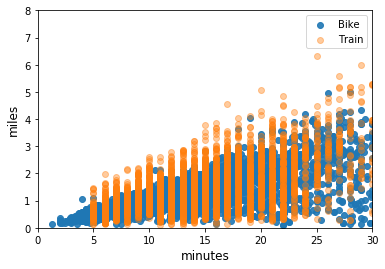

In [213]:
# Visualization
fig = plt.figure()
plt.scatter(x = mainTestOutputDF['bikeMins'],y = mainTestOutputDF['coorDistance'], alpha = 0.9)
plt.scatter(x = mainTestOutputDF['trainMins'],y = mainTestOutputDF['coorDistance'], alpha = 0.4)
# fig.suptitle('Travel Time per Mile', fontsize=20)
plt.xlabel('minutes', fontsize=12)
plt.ylabel('miles', fontsize=12)
plt.legend(["Bike","Train"])
# Remove outliers
plt.xlim(0,30)#minutes
plt.ylim(0,8) #miles

In [184]:
# Calculate the average distance where bike is faster than train
count = 0
bikeFasterCount = 0
for t_id, trip in mainTestOutputDF.iterrows():
    count += 1
    if trip["bikeMins"] < trip["trainMins"]:
        bikeFasterCount += 1
        
print(bikeFasterCount/count)
        

0.463420057816322


In [88]:
# plt.scatter(x = clean_data2['coorDistance'], y = clean_data2['bikeMins'], alpha = 0.1)
# plt.scatter(x = clean_data2['coorDistance'], y = clean_data2['trainMins'], alpha = 0.1)

In [89]:
#quickestTrainTime = nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph,oName,dName, weight = "time") + math.floor(nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph, oName, dName)/3)*3

In [90]:
# Determine which trips were faster riding a bike

# tripsFasterWithBike = 0
# for t_id, trip in mainTestOutputDF.iterrows():
#     if trip['trainMins'] > trip['bikeMins']:
#         tripsFasterWithBike = tripsFasterWithBike + 1
        
# print("There are:", tripsFasterWithBike, "Faster trips with a bike out of", len(mainTestOutputDF) ,"trips.")

In [91]:
#  Get the coordinates of lots of possible bike trips
#  Use this to compile the Uber data.
def computeSetOfCoords():
    setOfCoordinates = {}
    for i in range(0,100):
        (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()
        setOfCoordinates[i] = {"randLat1":randLat1, "randLong1":randLong1, "randLat2":randLat2, "randLong2":randLong2, "oBike":oBike, "dBike":dBike, "coorDistance":coorDistance}

    setOfCoordinatesDF = pd.DataFrame.from_dict(setOfCoordinates, orient="index")
    setOfCoordinatesDF.to_csv("../uber/setOfCoordinates.csv")
    
    return setOfCoordinatesDF

#setOfCoordinatesDF

In [223]:
# Fetches equivalant trip data for uber rides by asking the Uber API directly.  
def askUberForInfo():
    
    uberResults = {}
    uberRawResults = {}
    tokens = ["JA.VUNmGAAAAAAAEgASAAAABwAIAAwAAAAAAAAAEgAAAAAAAAG8AAAAFAAAAAAADgAQAAQAAAAIAAwAAAAOAAAAkAAAABwAAAAEAAAAEAAAANtHflT8X6DoYgIpCEVvhHRsAAAA2UI88meKNaFqi1aP8LM1syhGcTLmrN3bvmRGohrWvljT6ALAFnJJKdfgTlqnnl50IsXy1CwvcUQTysW5bpMrhGFKOokiYeaMZpxikirFh12Vyrf9mmLsSL0vfx3wg820TuLjp6GGxAoU6tInDAAAAJDaK7uypaWVZxNPcSQAAABiMGQ4NTgwMy0zOGEwLTQyYjMtODA2ZS03YTRjZjhlMTk2ZWU", 'JA.VUNmGAAAAAAAEgASAAAABwAIAAwAAAAAAAAAEgAAAAAAAAG8AAAAFAAAAAAADgAQAAQAAAAIAAwAAAAOAAAAkAAAABwAAAAEAAAAEAAAAM_yxbT1BPzwSOymOXStGetsAAAAurbsvx8OqXR8FI774FPoE9iTS93TFkHrFEjA_FOAAufTRMemHv0eMmLuSkRvONJBQEX5ESAzxYyq-DZJjxJiCPUXRLRBwSQ_LzYQJN4JURYF7G70x8oGJXOGGof8fAswKOfA7RtKsbaIy-PfDAAAAE0SqVeUlRC5cN9KryQAAABiMGQ4NTgwMy0zOGEwLTQyYjMtODA2ZS03YTRjZjhlMTk2ZWU','JA.VUNmGAAAAAAAEgASAAAABwAIAAwAAAAAAAAAEgAAAAAAAAG8AAAAFAAAAAAADgAQAAQAAAAIAAwAAAAOAAAAkAAAABwAAAAEAAAAEAAAAMswH7vSMNlBOXSNVxsX7BJsAAAACKszwJhNzfFi2nPv1m7aCbCPeTFFG6ntVaw6dAoUnwa47cTsDmK6jpnSh6kVOJXPhGRDVCAZXh-2iHslwDj7_x1FsyhO4nl7S0pxfVN4zFfk7v1-gBsY_-5z9gNZl6jQ70qVXQSy5YLMwvv5DAAAAJ0myYCyXBVu-jv69yQAAABiMGQ4NTgwMy0zOGEwLTQyYjMtODA2ZS03YTRjZjhlMTk2ZWU']
    idx = 0
    
    for token in tokens:
        setOfCoordinatesDF = computeSetOfCoords()
        for e_idx, element in setOfCoordinatesDF.iterrows():
            
            if (element["oBike"] == element["dBike"]):
                continue


            a = element['randLat1']
            b = element['randLong1']
            c = element['randLat2']
            d = element['randLong2']
            
            tokenStr = "Bearer " + token

            data = json.dumps({"start_latitude": a,"start_longitude": b,"end_latitude": c,"end_longitude": d})
            headers = {'Content-Type': 'application/json', 'Authorization': tokenStr}
            r = requests.post('https://api.uber.com/v1.2/requests/estimate', headers=headers, data=data)

            response = r.json()
            print(r.status_code, "for #", idx)

            if (r.status_code != 200):
                print("Encountered Error with API on iteration", idx)
                print(response)
                break

            uberTripTime = response["trip"]["duration_estimate"]
            uberTripDistance = response["trip"]["distance_estimate"]
            uberTripValue = response['estimate']['display']
            
            
            # Increment Global index
            idx = idx + 1

            uberResults[idx] = {"originBikeStation": int(element["oBike"]), 
                                  "destBikeStation": int(element["dBike"]), 
                                  "uberTripTime":uberTripTime, 
                                  "uberTripDistance": uberTripDistance, 
                                  "uberTripValue": uberTripValue}

            uberRawResults[idx] = response

        uberResultsDF = pd.DataFrame.from_dict(uberResults, orient="index")
        rawUberResultsDF = pd.DataFrame.from_dict(uberRawResults, orient="index")
        timeStamp = int(time.time())
        uberResultsDF.to_csv("../uber/uberResults" + str(timeStamp) + ".csv")
        rawUberResultsDF.to_csv("../uber/uberRawResults" + str(timeStamp) + ".csv")

    return uberResultsDF, rawUberResultsDF



In [224]:
# RUNS API SCRIPT
# Generate a set of coordinates that is a valid trips on bikes
# Calculate an equivalant trip with Uber by asking Uber's API.  (Gets the price and travel time)

uberResultsDF, rawUberResultsDF = askUberForInfo()



200 for # 0
200 for # 1
200 for # 2
200 for # 3
200 for # 4
200 for # 5
200 for # 6
200 for # 7
200 for # 8
200 for # 9
200 for # 10
200 for # 11
200 for # 12
200 for # 13
200 for # 14
200 for # 15
200 for # 16
200 for # 17
200 for # 18
200 for # 19
200 for # 20
200 for # 21
200 for # 22
200 for # 23
200 for # 24
200 for # 25
200 for # 26
200 for # 27
200 for # 28
200 for # 29
200 for # 30
200 for # 31
200 for # 32
200 for # 33
200 for # 34
200 for # 35
200 for # 36
200 for # 37
200 for # 38
200 for # 39
200 for # 40
200 for # 41
200 for # 42
200 for # 43
200 for # 44
200 for # 45
200 for # 46
200 for # 47
200 for # 48
200 for # 49
200 for # 50
200 for # 51
200 for # 52
200 for # 53
200 for # 54
200 for # 55
200 for # 56
200 for # 57
200 for # 58
200 for # 59
200 for # 60
200 for # 61
200 for # 62
200 for # 63
200 for # 64
200 for # 65
200 for # 66
200 for # 67
200 for # 68
200 for # 69
200 for # 70
200 for # 71
200 for # 72
200 for # 73
200 for # 74
200 for # 75
200 for # 76
200 for #

In [103]:
########## MAIN EXPERIMENT WITH UBER #######
# Iterates through uber trip data, 
# using the stored origin station and destination to calculate bike and train trips.

mainTestOutputWithUber = {}


for u_id, uberTrip in uberTripData.iterrows(): ### RUNNING ON A PRE-MADE DATASET LOADED IN THE BEGINNING
    print("[!] Iteration", u_id)

    # (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()
    oBike = uberTrip['originBikeStation']
    dBike = uberTrip['destBikeStation']
    
    uberTripTime = uberTrip['uberTripTime']
    uberTripDistance = uberTrip['uberTripDistance']
    uberTripValue = uberTrip['uberTripValue']
    
    originLat  =  bikeDockingStations.at[oBike, "station__lat"]
    originLong =  bikeDockingStations.at[oBike, "station__long"]
    destLat  =    bikeDockingStations.at[dBike, "station__lat"]
    destLong =    bikeDockingStations.at[dBike, "station__long"]
    
    # Calculate the nearest origin and destination stations, given the random coordinates.
    (oTrain,dTrain) = closestTubeStation(originLat, originLong, destLat, destLong)

    # Calculate the minimum/average travel time (with our data) given an origin and a destination.
    trainMins = calcTrainTravelTimeMins(oTrain,dTrain)
    bikeMins = calcBikeTravelTimeMins(oBike, dBike)

    if bikeMins == -1 or trainMins == -1 or (oTrain == dTrain):
        print("Skipping this one...")
        continue
    
    uberMins = 0
    if uberTripTime > 0:
        uberMins = uberTripTime / 60    
        
    mainTestOutputWithUber[u_id] = {
        "oLat": originLat,
        "oLong": originLong,
        "dLat": destLat,
        "dLong": destLong,
        "uberTripDistance": uberTripDistance,
        "uberTripValue": uberTripValue,
        "oTrain": oTrain, 
        "dTrain": dTrain,
        "oBike": oBike,
        "dBike": dBike,
        "bikeMins": bikeMins,
        "trainMins": trainMins,
        "uberMins": uberMins}
    
mainTestOutputWithUberDF = pd.DataFrame.from_dict(mainTestOutputWithUber, orient="index")

[!] Iteration 0
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  10 minutes.
88 44246 44838
For bikes there were: 47 exact matches.
The average time of this BIKE trip is: 8.23404255319149 minutes.
[!] Iteration 1
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  14 minutes.
46 24042 24809
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 7.25 minutes.
[!] Iteration 2
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  18 minutes.
169 84333 84903
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 6.6 minutes.
[!] Itera

For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 9.733333333333333 minutes.
[!] Iteration 26
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  16 minutes.
14 5428 8543
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 16.25 minutes.
[!] Iteration 27
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  19 minutes.
372 173953 174333
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.333333333333334 minutes.
[!] Iteration 28
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  16 minutes.
36

The average time of this BIKE trip is: 16.076923076923077 minutes.
[!] Iteration 55
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Bank 51.5133 -0.0886
The quickest time for this TRAIN trip is  8 minutes.
319 152655 153128
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 7.875 minutes.
[!] Iteration 56
Nearest train station to Random Origin: Warren Street 51.5247 -0.1384
Nearest train station to Random Destination: St. John's Wood 51.5347 -0.174
The quickest time for this TRAIN trip is  20 minutes.
239 119488 120151
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 15.5 minutes.
[!] Iteration 57
Nearest train station to Random Origin: Embankment 51.5074 -0.1223
Nearest train station to Random Destination: Russell Square 51.523 -0.1244
The quickest time for this TRAIN trip is  15 minutes.
354 166738 167207
For bikes there were: 2 exact matches.
The average time of th

Nearest train station to Random Origin: Putney Bridge 51.4682 -0.2089
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  16 minutes.
774 296575 296692
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 27.5 minutes.
[!] Iteration 81
Nearest train station to Random Origin: Oxford Circus 51.515 -0.1415
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  6 minutes.
116 59622 60398
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 82
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  14 minutes.
226 113561 113975
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 83
Nearest train station t

For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 7.3076923076923075 minutes.
[!] Iteration 115
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  0 minutes.
737 285524 286322
For bikes there were: 33 exact matches.
The average time of this BIKE trip is: 3.3333333333333335 minutes.
Skipping this one...
[!] Iteration 116
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  0 minutes.
729 282270 282652
For bikes there were: 90 exact matches.
The average time of this BIKE trip is: 3.3 minutes.
Skipping this one...
[!] Iteration 117
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for thi

Nearest train station to Random Origin: Monument 51.5108 -0.0863
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  8 minutes.
199 99548 100476
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 9.11111111111111 minutes.
[!] Iteration 146
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  0 minutes.
310 150304 150653
For bikes there were: 16 exact matches.
The average time of this BIKE trip is: 4.125 minutes.
Skipping this one...
[!] Iteration 147
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  17 minutes.
507 216647 216843
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 8.666666666666666 minutes.
[!] Iteration 

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 13.285714285714285 minutes.
[!] Iteration 177
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  14 minutes.
136 69414 70023
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.333333333333334 minutes.
[!] Iteration 178
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  12 minutes.
108 54838 55325
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 12.8 minutes.
[!] Iteration 179
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  10 minutes.
374 174646 17

Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  10 minutes.
589 242199 242664
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 6.25 minutes.
[!] Iteration 203
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  22 minutes.
187 91454 91836
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 54.0 minutes.
[!] Iteration 204
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  23 minutes.
250 124365 124636
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 22.0 minutes.
[!] Iteration 205
Nearest train sta

Nearest train station to Random Destination: Warwick Avenue 51.5235 -0.1835
The quickest time for this TRAIN trip is  20 minutes.
329 156631 156952
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 229
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Aldgate East 51.5154 -0.0726
The quickest time for this TRAIN trip is  18 minutes.
695 271479 272327
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 230
Nearest train station to Random Origin: Stratford 51.5416 -0.0042
Nearest train station to Random Destination: Leyton 51.5566 -0.0053
The quickest time for this TRAIN trip is  6 minutes.
785 299324 300337
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 231
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination:

Nearest train station to Random Origin: Aldgate East 51.5154 -0.0726
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  11 minutes.
200 100477 100845
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 255
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  15 minutes.
9 3006 3465
For bikes there were: 29 exact matches.
The average time of this BIKE trip is: 7.827586206896552 minutes.
[!] Iteration 256
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  20 minutes.
78 40336 40904
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 9.714285714285715 minutes.
[!] Iteration 257
Nearest train station

Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  9 minutes.
4 1322 1609
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 280
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  15 minutes.
101 50037 51387
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 7.454545454545454 minutes.
[!] Iteration 281
Nearest train station to Random Origin: Royal Oak 51.519 -0.188
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  20 minutes.
568 234605 235033
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 282
Nearest train

Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Edgware Road (C) 51.5203 -0.17
The quickest time for this TRAIN trip is  17 minutes.
192 94944 95599
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 314
Nearest train station to Random Origin: Green Park 51.5067 -0.1428
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  14 minutes.
541 226517 227554
For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 20.318181818181817 minutes.
[!] Iteration 315
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  5 minutes.
230 116066 116548
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 5.75 minutes.
[!] Iteration 316
Nearest t

Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  12 minutes.
331 157413 158037
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 19.333333333333332 minutes.
[!] Iteration 342
Nearest train station to Random Origin: West Kensington 51.4907 -0.2065
Nearest train station to Random Destination: Putney Bridge 51.4682 -0.2089
The quickest time for this TRAIN trip is  13 minutes.
626 252811 253272
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 8.571428571428573 minutes.
[!] Iteration 343
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  0 minutes.
588 241933 242198
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 4.333333333333333 minutes.
Skipping this one...
[!] Iteration 344
Nearest train station to Rand

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 10.857142857142858 minutes.
[!] Iteration 371
Nearest train station to Random Origin: West Kensington 51.4907 -0.2065
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  10 minutes.
633 254400 254799
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.833333333333334 minutes.
[!] Iteration 372
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Queensway 51.5107 -0.1877
The quickest time for this TRAIN trip is  8 minutes.
111 56558 57692
For bikes there were: 36 exact matches.
The average time of this BIKE trip is: 34.88888888888889 minutes.
[!] Iteration 373
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Limehouse 51.5123 -0.0396
The quickest time for this TRAIN trip is  19 minutes.
779 297139 29

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 20.5 minutes.
[!] Iteration 398
Nearest train station to Random Origin: Hammersmith 51.4936 -0.2251
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  13 minutes.
730 282653 283017
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 14.5 minutes.
[!] Iteration 399
Nearest train station to Random Origin: Hammersmith 51.4936 -0.2251
Nearest train station to Random Destination: Kensington (Olympia) 51.4983 -0.2106
The quickest time for this TRAIN trip is  10 minutes.
730 282653 283017
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 10.428571428571427 minutes.
[!] Iteration 400
Nearest train station to Random Origin: Shepherd's Bush (C) 51.5046 -0.2187
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  15 minutes.
647 258903 259226

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 6.5 minutes.
[!] Iteration 431
Nearest train station to Random Origin: St. Paul's 51.5146 -0.0973
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  16 minutes.
48 25299 26103
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 432
Nearest train station to Random Origin: Bow Church 51.5273 -0.0208
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  26 minutes.
495 213390 213680
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 67.5 minutes.
[!] Iteration 433
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Whitechapel 51.5194 -0.0612
The quickest time for this TRAIN trip is  16 minutes.
263 129393 129845
For bikes there were: 4 exact matches.
The 

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 21.0 minutes.
[!] Iteration 462
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Embankment 51.5074 -0.1223
The quickest time for this TRAIN trip is  8 minutes.
762 292324 293473
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 22.5 minutes.
[!] Iteration 463
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  13 minutes.
9 3006 3465
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 464
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  9 minutes.
733 284520 284858
For bikes there wer

For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 44.94117647058824 minutes.
[!] Iteration 496
Nearest train station to Random Origin: Marylebone 51.5225 -0.1631
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  9 minutes.
605 246782 247148
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 497
Nearest train station to Random Origin: Russell Square 51.523 -0.1244
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  6 minutes.
57 29841 30359
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 5.0 minutes.
[!] Iteration 498
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  7 minutes.
85 42956 43518
For 

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 6.142857142857142 minutes.
[!] Iteration 530
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  16 minutes.
432 195088 195601
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 13.857142857142858 minutes.
[!] Iteration 531
Nearest train station to Random Origin: Brixton 51.4627 -0.1145
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  31 minutes.
829 311632 311652
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 23.0 minutes.
[!] Iteration 532
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  11 minutes.
588 241933 242198
For bikes t

Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: West Brompton 51.4872 -0.1953
The quickest time for this TRAIN trip is  10 minutes.
187 91454 91836
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 7.333333333333333 minutes.
[!] Iteration 557
Nearest train station to Random Origin: Putney Bridge 51.4682 -0.2089
Nearest train station to Random Destination: East Putney 51.4586 -0.2112
The quickest time for this TRAIN trip is  6 minutes.
693 271087 271304
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 558
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Putney Bridge 51.4682 -0.2089
The quickest time for this TRAIN trip is  9 minutes.
701 273773 274215
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 22.666666666666668 minutes.
[!] Iteratio

For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 7.454545454545454 minutes.
[!] Iteration 587
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  9 minutes.
428 193843 194664
For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 31.27272727272727 minutes.
[!] Iteration 588
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: Royal Oak 51.519 -0.188
The quickest time for this TRAIN trip is  21 minutes.
219 110288 110787
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 589
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: Euston 51.5282 -0.1337
The quickest time for this TRAIN trip is  8 minutes.
15 8544 9036

For bikes there were: 25 exact matches.
The average time of this BIKE trip is: 57.080000000000005 minutes.
[!] Iteration 613
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  32 minutes.
615 249415 249771
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 43.25 minutes.
[!] Iteration 614
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  16 minutes.
290 140957 141740
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 73.4 minutes.
[!] Iteration 615
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  21 minutes.
446 199537 200055
For bik

Nearest train station to Random Origin: Baker Street 51.5226 -0.1571
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  16 minutes.
56 29514 29840
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 18.5 minutes.
[!] Iteration 651
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  0 minutes.
195 97852 98676
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 5.75 minutes.
Skipping this one...
[!] Iteration 652
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Clapham Common 51.4618 -0.1384
The quickest time for this TRAIN trip is  31 minutes.
157 79274 79909
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 22.666666666666668 minutes.
[!] Ite

169 84333 84903
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 681
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  16 minutes.
268 131596 132195
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 682
Nearest train station to Random Origin: Barons Court 51.4905 -0.2139
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  0 minutes.
635 255077 255404
For bikes there were: 44 exact matches.
The average time of this BIKE trip is: 3.227272727272727 minutes.
Skipping this one...
[!] Iteration 683
Nearest train station to Random Origin: Covent Garden 51.5129 -0.1243
Nearest train station to Random Destination: Warren Street 51.5247 -0.1384
The quickest time for this TRAIN trip is  13 min

Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  15 minutes.
4 1322 1609
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 715
Nearest train station to Random Origin: White City 51.512 -0.2239
Nearest train station to Random Destination: White City 51.512 -0.2239
The quickest time for this TRAIN trip is  0 minutes.
566 234490 234603
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 9.166666666666666 minutes.
Skipping this one...
[!] Iteration 716
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  22 minutes.
263 129393 129845
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 717


Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  20 minutes.
695 271479 272327
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 31.333333333333332 minutes.
[!] Iteration 749
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  19 minutes.
67 34181 34717
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 750
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  15 minutes.
194 96368 97851
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 751
Nearest train station to Random Origin: East Putney 51.4586 -0.2112
Nearest train station to 

Nearest train station to Random Origin: Euston 51.5282 -0.1337
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  6 minutes.
214 106452 107097
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 6.666666666666667 minutes.
[!] Iteration 784
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  10 minutes.
249 124217 124364
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 7.5 minutes.
[!] Iteration 785
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  15 minutes.
411 189502 189978
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 22.0 minutes.
[!] Iteration 786
Nearest 

Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  6 minutes.
51 26774 27099
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 7.363636363636363 minutes.
[!] Iteration 817
Nearest train station to Random Origin: Queensway 51.5107 -0.1877
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  8 minutes.
307 148082 149640
For bikes there were: 30 exact matches.
The average time of this BIKE trip is: 38.0 minutes.
[!] Iteration 818
Nearest train station to Random Origin: Baker Street 51.5226 -0.1571
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  11 minutes.
114 58447 58966
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 29.333333333333332 minutes.
[!] Iteration 819
Nearest train station to Random Origin: Limehouse 51

Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  0 minutes.
492 212707 213360
For bikes there were: 26 exact matches.
The average time of this BIKE trip is: 14.538461538461538 minutes.
Skipping this one...
[!] Iteration 856
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  18 minutes.
197 99042 99546
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 857
Nearest train station to Random Origin: Wapping 51.5043 -0.0558
Nearest train station to Random Destination: Embankment 51.5074 -0.1223
The quickest time for this TRAIN trip is  24 minutes.
458 203322 203740
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 27.5 minutes.
[!] Iteration 858
Nearest train stat

Nearest train station to Random Origin: Latimer Road 51.5139 -0.2172
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  20 minutes.
754 289970 290131
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 16.5 minutes.
[!] Iteration 885
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  19 minutes.
427 192626 193842
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 8.555555555555555 minutes.
[!] Iteration 886
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  5 minutes.
356 167285 168306
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 5.11764705882353 minutes.
[!] I

Nearest train station to Random Destination: Charing Cross 51.508 -0.1247
The quickest time for this TRAIN trip is  11 minutes.
174 86115 86648
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 14.23076923076923 minutes.
[!] Iteration 930
Nearest train station to Random Origin: Covent Garden 51.5129 -0.1243
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  14 minutes.
388 181066 181651
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 931
Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  15 minutes.
664 263440 263750
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 932
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train statio

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 18.5 minutes.
[!] Iteration 965
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  16 minutes.
773 295882 296574
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 966
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  13 minutes.
620 250741 251053
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 967
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: Warwick Avenue 51.5235 -0.1835
The quickest time for this TRAIN trip is  6 minutes.
186 90963 91453
For bikes there were

[!] Iteration 997
Nearest train station to Random Origin: Embankment 51.5074 -0.1223
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  18 minutes.
229 115183 116065
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 21.666666666666668 minutes.
[!] Iteration 998
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Euston Square 51.526 -0.1359
The quickest time for this TRAIN trip is  12 minutes.
93 45968 46350
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 999
Nearest train station to Random Origin: Russell Square 51.523 -0.1244
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  6 minutes.
57 29841 30359
For bikes there were: 59 exact matches.
The average time of this BIKE trip is: 4.59322033898305 minutes.
[!] It

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 21.0 minutes.
[!] Iteration 1027
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Earl's Court 51.492 -0.1973
The quickest time for this TRAIN trip is  7 minutes.
746 287800 288011
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 1028
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  0 minutes.
38 19800 20039
For bikes there were: 35 exact matches.
The average time of this BIKE trip is: 2.6285714285714286 minutes.
Skipping this one...
[!] Iteration 1029
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Devons Road 51.5223 -0.0173
The quickest time for this TRAIN t

For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 16.125 minutes.
[!] Iteration 1052
Nearest train station to Random Origin: Tower Hill 51.5098 -0.0766
Nearest train station to Random Destination: Aldgate East 51.5154 -0.0726
The quickest time for this TRAIN trip is  6 minutes.
130 65421 66148
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 1053
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  9 minutes.
219 110288 110787
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 7.470588235294118 minutes.
[!] Iteration 1054
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  16 minutes.
58 30360 30927
For bik

Nearest train station to Random Origin: Green Park 51.5067 -0.1428
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  6 minutes.
541 226517 227554
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 24.30769230769231 minutes.
[!] Iteration 1082
Nearest train station to Random Origin: All Saints 51.5107 -0.013000000000000001
Nearest train station to Random Destination: Whitechapel 51.5194 -0.0612
The quickest time for this TRAIN trip is  18 minutes.
516 220058 220263
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[!] Iteration 1083
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  21 minutes.
192 94944 95599
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 20.666666666666668 minutes.
[!] Itera

Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  7 minutes.
376 176730 177332
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 7.909090909090909 minutes.
[!] Iteration 1107
Nearest train station to Random Origin: Bayswater 51.5121 -0.1879
Nearest train station to Random Destination: Putney Bridge 51.4682 -0.2089
The quickest time for this TRAIN trip is  20 minutes.
29 15958 16314
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 24.0 minutes.
[!] Iteration 1108
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  14 minutes.
46 24042 24809
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 1109
Nearest train station to 

Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  15 minutes.
102 51388 51805
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 17.5 minutes.
[!] Iteration 1144
Nearest train station to Random Origin: Marylebone 51.5225 -0.1631
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is  23 minutes.
182 89332 89711
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.5 minutes.
[!] Iteration 1145
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  12 minutes.
465 205442 206081
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 13.25 minutes.
[!] Iteration 1146
Nearest train station to Random Origin: M

Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  15 minutes.
503 215454 215973
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 1174
Nearest train station to Random Origin: Baker Street 51.5226 -0.1571
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  5 minutes.
56 29514 29840
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 8.8 minutes.
[!] Iteration 1175
Nearest train station to Random Origin: Oval 51.4819 -0.113
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  8 minutes.
305 147601 147815
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 6.5 minutes.
[!] Iteration 1176
Nearest train station to Random Origin

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 1201
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  0 minutes.
798 303892 304525
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 5.777777777777778 minutes.
Skipping this one...
[!] Iteration 1202
Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  19 minutes.
110 56326 56557
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 1203
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  0 minutes.


Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  13 minutes.
631 253902 254182
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.333333333333334 minutes.
[!] Iteration 1233
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  7 minutes.
755 290132 290666
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 12.666666666666666 minutes.
[!] Iteration 1234
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  6 minutes.
593 243387 243704
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 4.333333333333333 minute

Nearest train station to Random Origin: Wapping 51.5043 -0.0558
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  9 minutes.
488 211226 211608
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 1265
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  15 minutes.
739 286577 286832
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 21.0 minutes.
[!] Iteration 1266
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  21 minutes.
486 210493 211060
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 7.5 minutes.
[!] Iteration 1267
Nearest train station to Random Ori

[!] Iteration 1291
Nearest train station to Random Origin: Limehouse 51.5123 -0.0396
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  21 minutes.
480 208866 209437
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 1292
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Edgware Road (B) 51.5199 -0.1679
The quickest time for this TRAIN trip is  20 minutes.
66 33223 34180
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 24.0 minutes.
[!] Iteration 1293
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  20 minutes.
248 122695 124216
For bikes there were: 122 exact matches.
The average time of this BIKE trip is: 32.00819672131148

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 1327
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  15 minutes.
779 297139 297501
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 1328
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  8 minutes.
320 153129 153688
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 10.5 minutes.
[!] Iteration 1329
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  17 minutes.
191 92980 94943
For bikes there were: 103 exact matches

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  7 minutes.
574 237025 237996
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 1359
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  6 minutes.
746 287800 288011
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 1360
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  17 minutes.
2 284 750
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 52.90909090909091 minutes.
[!] Iteration 1361
Nearest train st

The average time of this BIKE trip is: 18.333333333333332 minutes.
Skipping this one...
[!] Iteration 1395
Nearest train station to Random Origin: Marylebone 51.5225 -0.1631
Nearest train station to Random Destination: Shepherd's Bush (C) 51.5046 -0.2187
The quickest time for this TRAIN trip is  24 minutes.
182 89332 89711
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 20.666666666666668 minutes.
[!] Iteration 1396
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  5 minutes.
94 46351 46833
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 4.0 minutes.
[!] Iteration 1397
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  18 minutes.
380 178618 178844


For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 6.909090909090909 minutes.
[!] Iteration 1442
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  8 minutes.
797 303492 303891
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 8.571428571428573 minutes.
[!] Iteration 1443
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Bank 51.5133 -0.0886
The quickest time for this TRAIN trip is  8 minutes.
574 237025 237996
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 11.666666666666666 minutes.
[!] Iteration 1444
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  8 minutes.
216

In [105]:
# Dataframe of output dataset
mainTestOutputWithUberDF

oLat     oLong       dLat     dLong  uberTripDistance  \
0     51.518588 -0.132053  51.529944 -0.123617              1.25   
1     51.507131 -0.066910  51.503494 -0.079621              1.85   
2     51.514746 -0.165164  51.516417 -0.179135              0.88   
3     51.501855 -0.159237  51.500089 -0.116629              2.12   
4     51.504038 -0.217400  51.496101 -0.208158              0.95   
5     51.496753 -0.138734  51.514578 -0.158264              2.04   
6     51.485587 -0.181190  51.487244 -0.205279              1.41   
7     51.536039 -0.026263  51.539084 -0.070329              2.45   
8     51.508981 -0.006990  51.540940 -0.010511              2.96   
9     51.523260 -0.104709  51.508446 -0.131961              2.06   
10    51.494224 -0.236770  51.501595 -0.222293              1.35   
11    51.515607 -0.183119  51.496101 -0.208158              3.70   
13    51.534043 -0.086380  51.507131 -0.066910              2.76   
14    51.521889 -0.046670  51.514223 -0.055656              0.82   
15    51.521681 -0.130432  51.514771 -0.122220              1.09   
16    51.502042 -0.184400  51.503118 -0.153521              1.37   
17    51.504628 -0.091774  51.506613 -0.142844              3.15   
18    51.504028 -0.113864  51.517428 -0.107987              1.77   
19    51.519064 -0.059642  51.521681 -0.130432              4.85   
20    51.524696 -0.084439  51.526008 -0.096318              0.83   
22    51.529423 -0.097122  51.519069 -0.088285              1.05   
23    51.515060 -0.105344  51.504860 -0.113001              1.39   
24    51.506230 -0.022960  51.511542 -0.056667              2.17   
25    51.529944 -0.123617  51.523260 -0.104709              1.47   
26    51.529944 -0.123617  51.503792 -0.112824              3.08   
27    51.515208 -0.117863  51.505818 -0.100186              1.49   
28    51.501737 -0.184981  51.502954 -0.158456              1.20   
29    51.514746 -0.165164  51.506452 -0.170280              0.93   
30    51.488024 -0.166879  51.465064 -0.163751              1.81   
31    51.510017 -0.157276  51.492480 -0.178433              2.71   
...         ...       ...        ...       ...               ...   
1433  51.536585 -0.075886  51.536425 -0.054162              1.45   
1434  51.528936 -0.055894  51.534137 -0.037366              0.93   
1435  51.507770 -0.130700  51.509640 -0.084970              2.29   
1436  51.499429 -0.179702  51.495867 -0.191934              1.19   
1437  51.505569 -0.111607  51.500647 -0.078600              2.15   
1438  51.519265 -0.021345  51.523538 -0.030556              0.89   
1439  51.492462 -0.159919  51.473764 -0.197010              2.66   
1440  51.509992 -0.143495  51.477619 -0.149552              3.15   
1441  51.520859 -0.089888  51.526008 -0.096318              0.66   
1442  51.529300 -0.128279  51.518240 -0.116550              1.38   
1443  51.533560 -0.093150  51.514441 -0.087587              1.54   
1444  51.490946 -0.181191  51.498884 -0.165472              1.02   
1445  51.474376 -0.155443  51.473117 -0.137235              1.59   
1446  51.512276 -0.157437  51.518118 -0.144229              1.09   
1447  51.515631 -0.132329  51.529944 -0.123617              2.06   
1448  51.487959 -0.187405  51.495867 -0.191934              0.82   
1450  51.493700 -0.121394  51.496753 -0.138734              0.93   
1451  51.532662 -0.099981  51.534464 -0.076341              1.47   
1453  51.494186 -0.182671  51.484985 -0.167920              1.14   
1454  51.523648 -0.074755  51.509302 -0.084985              2.02   
1455  51.497383 -0.089447  51.511891 -0.107349              1.91   
1456  51.519530 -0.135777  51.525051 -0.131161              0.83   
1457  51.489856 -0.141924  51.500703 -0.129699              1.14   
1458  51.509992 -0.143495  51.519080 -0.124678              1.91   
1459  51.516780 -0.175489  51.511968 -0.120719              3.70   
1461  51.466907 -0.216573  51.485587 -0.181190              2.34   
1462  51.512901 -0.214763  51.514312 -0.200838              0.91   

(0, 8)

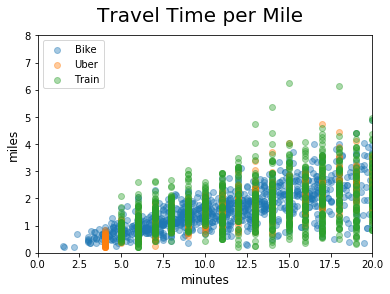

In [225]:
# Plot the trip distances (miles) vs. time (all three modes)

fig = plt.figure()
plt.scatter(x = mainTestOutputWithUberDF['bikeMins'],y = mainTestOutputWithUberDF['uberTripDistance'], alpha = 0.4)
plt.scatter(x = mainTestOutputWithUberDF['uberMins'],y = mainTestOutputWithUberDF['uberTripDistance'], alpha = 0.4)
plt.scatter(x = mainTestOutputWithUberDF['trainMins'],y = mainTestOutputWithUberDF['uberTripDistance'], alpha = 0.4)
fig.suptitle('Travel Time per Mile', fontsize=20)
plt.xlabel('minutes', fontsize=12)
plt.ylabel('miles', fontsize=12)
plt.legend(["Bike","Uber","Train"])
# Remove outliers
plt.xlim(0,20)#minutes
plt.ylim(0,8) #miles


In [226]:
bikeGraph = nx.Graph()

# Add in all the bike docking station nodes.
for s_id, dockingStation in bikeDockingStations.iterrows():
    
     bikeGraph.add_node(s_id, coordinates=(dockingStation["station__lat"],dockingStation["station__long"]), name=dockingStation['station__name'])

        
#     startLocation = trip['oBike']
#     endLocation = trip['dBike']
#     bikeUberGraph.add_node(1, time='5pm')#     tubeGraph.add_edge(startLocation, endLocation)

In [221]:
def minTimeModeOfTransportColor(edge):
    bikeMins = bikeGraph[edge[0]][edge[1]]['weight'] #0 - Blue
    trainMins = bikeGraph[edge[0]][edge[1]]['trainMins'] #1 - Green
    uberMins = bikeGraph[edge[0]][edge[1]]['uberMins'] #2 - Orange
    minNum = np.argmin([bikeMins,trainMins,uberMins])
    if minNum == 0:
        return "blue"
    if minNum == 1:
        return "green"
    if minNum == 2:
        return "orange"
    


for t_id, trip in mainTestOutputWithUberDF.iterrows():
    bikeGraph.add_edge(trip["oBike"], 
                       trip["dBike"], 
                       weight=trip['bikeMins'], 
                       trainMins=trip['trainMins'], 
                       uberMins=trip['uberMins'])
    
# nx.draw(bikeGraph, nx.get_node_attributes(bikeGraph, 'coordinates'), with_labels=False)


normalize = bikeDockingStations[['station__lat', 'station__long']]
normalize = normalize - normalize.min()
normalize = normalize / normalize.max()

locations = dict(zip(bikeDockingStations.index, normalize[['station__lat', 'station__long']].values))

p = figure(
    x_range = (-1,1),
    y_range = (-1,1),
    height= 1000,
    width= 1000,
)
for edge in bikeGraph.edges():
    

    p.line( 
        x= [locations[pt][0] for pt in edge],
        y= [locations[pt][1] for pt in edge],
        color=minTimeModeOfTransportColor(edge),
    )

for node in bikeGraph.nodes():
    x = [locations[node][0]]
    y = [locations[node][1]]
    p.circle(
        x, y, 
        radius = 0.005, 
        #fill_color = pseudocolor(pageranks[node]), 
        line_alpha=0)
    p.text(
        x, y, 
        text = {'value':str(node)}, 
        text_font_size = str(5) + "pt", 
        text_alpha = 1,
        text_align='center',
        text_font_style='bold')
    
show(p)
